## Spike Processing Pipeline ver 0.1a
This notebook specifes a preprocessing pipeline for neural data colleted on blackrock aquisition devices in the Hatsopoulos lab. The file assumes that spikeinterface(ver 0.13 - 0.10), python-neo, matplotlib, numpy, PHY, and pandas are installed. 

The code needs a datafile (ns6) and a probe file (you can find tony's its at /Paul/prbfiles/TY_array.prb). This script will automatically precondition the data (filtering and referencing), attach probe infomation (via .prb file) and pull out LFP data. The file will then sort the neural data with a number of different sorters, and comparitive sort to find the units common to all of the sorters (see https://elifesciences.org/articles/61834 ). Finally, it will convert the automatic sorting of one sorter (here Tridesclous is used) and mark the common units as 'good' in the phy output.

The user would then mark each cluster as good (SU), MUA (multiunit), or noise. For analysis, you could read the phy output directly (numpy files) or you could inmport back to spikeinterface and save.

Useful web sites:
spikeinterface docs (for old api): https://spikeinterface.readthedocs.io/en/0.13.0/
phy docs: https://phy.readthedocs.io/en/latest/
Useful info about .prb files): https://tridesclous.readthedocs.io/en/latest/important_details.html
                               https://spyking-circus.readthedocs.io/en/latest/code/probe.html

# preprocessing TY20221024_test battery

In [2]:
# import the necessary toolboxes
from datetime import datetime
import matplotlib.pyplot as plt
import spikeinterface
import spikeinterface.extractors as se 
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import numpy as np
import pandas as pd

# specify inline plotting
%matplotlib notebook

In [3]:
now = datetime.now()
start_time = now.strftime("%D at %H:%M:%S")
print('Start Time: ', start_time)

Start Time:  01/07/23 at 15:40:06


In [4]:
# User defined information about the data
pth = '/media/paul/storage/Data/Tony/' # path to data directory
sess = 'TY20221024_testbattery/' # directory where Ns6 file lives
file = 'TY20221024_testbattery_001' # name of NS6 file
prbfile = '/media/paul/storage/Data/Tony/TY_array.prb' # name of probe (.prb) file

In [5]:
# specify path to recording
recording_folder = pth+sess+file
print('recording_folder: ', recording_folder)
# load recording
recording = se.BlackrockRecordingExtractor(recording_folder)

recording_folder:  /media/paul/storage/Data/Tony/TY20221024_testbattery/TY20221024_testbattery_001


In [6]:
# load probe information
probefile = prbfile
print('probefile: ', probefile)
recording_prb = recording.load_probe_file(probefile)
# check that info correct properties are present (should be gain, group, location, name, and offset)
recording_prb.get_shared_channel_property_names()

probefile:  /media/paul/storage/Data/Tony/TY_array.prb


['gain', 'group', 'location', 'name', 'offset']

<IPython.core.display.Javascript object>


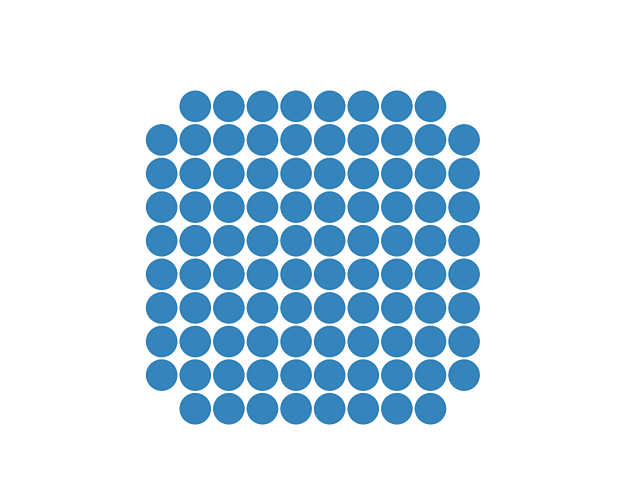

In [7]:
# visualize probe geometry: want to see that it looks correct
w_elec = sw.plot_electrode_geometry(recording_prb)

## Preprocessing
First step is common median filtering (the median across all channels is removed sample wise from the signal at each probe). Then the signal at each channel is low pass filtered and saved off as the lfp. The data is then bandpass filtered for spike processing. The filter values can be set, the defaults are 350Hz for LFP and 350-7500Hz for spikes. Some plots to review the data and save progress. The spike data is saved as a cache. All of the filtering is only done when the data is read. So to save time in future steps, we save the filtered/processed data to file.

In [8]:
# automagically attempt top find bad channels. need to then specify them in next cell. Don't forget to add 1 
# to the channel ID found in this step. Python zero based. amiright?
st.preprocessing.remove_bad_channels(recording_prb, verbose=True)

Automatically removing channels: [33, 66]


In [12]:
# remove bad channels
recording_rmc = st.preprocessing.remove_bad_channels(recording_prb, bad_channel_ids=[34, 67]) #[34, 50, 52, 67, 81])
# verify that all of the properties were transfered to the new recording object
recording_rmc.get_shared_channel_property_names()

['gain', 'group', 'location', 'name', 'offset']

In [13]:
# verify bad channels have been removed
print(recording_rmc.get_channel_ids())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96]


In [ ]:
# lowpass filter for lfp
recording_lp = st.preprocessing.bandpass_filter(recording_prb, freq_min=1, freq_max=350, 
                                                filter_type='butter', order=3)
# downsample
recording_lfp = st.preprocessing.resample(recording_lp, resample_rate=1000)

In [14]:
# bandpass filter for spikes
recording_f = st.preprocessing.bandpass_filter(recording_rmc, freq_min=350, freq_max=7500, 
                                               filter_type='butter', order=3)

In [15]:
# common median reference (skip if preCMR)
recording_cmr = st.preprocessing.common_reference(recording_f, reference='median')

<IPython.core.display.Javascript object>


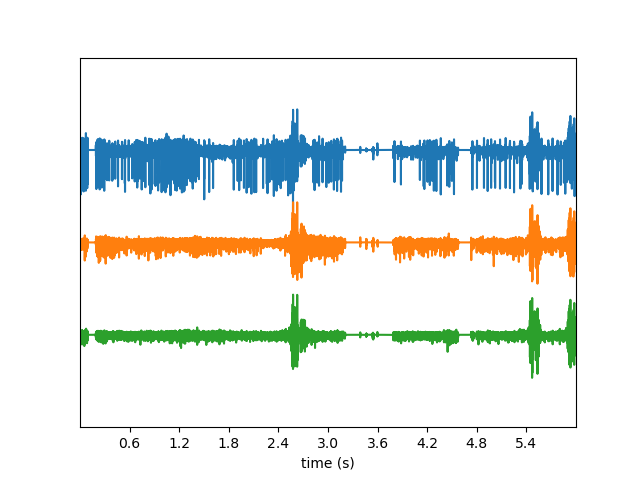

In [16]:
# view the signal on channels. channel_id is the probe and trange is the time sample to view in seconds
sw.plot_timeseries(recording_f, channel_ids=[2, 5, 7], trange=[0, 6])

<IPython.core.display.Javascript object>


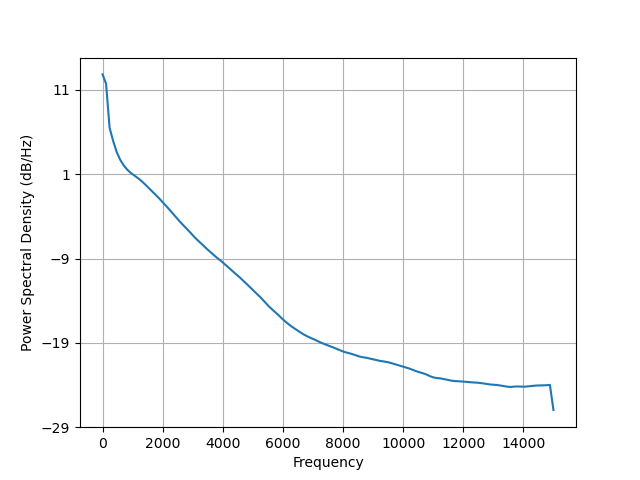

In [17]:
# view the power spectrum of the data. Check that the filtering looks reasonable. You can also look at the
# the raw data: recording, or the lfp: recording_lfp, or the spike data: recording_f
w_sp = sw.plot_spectrum(recording_prb, channels=[2])

In [18]:
# save preprocessed data for spikes and cache recording
recording_cache = se.CacheRecordingExtractor(recording_cmr, save_path=pth+sess+'processed/filtered_data.dat')
recording_cache.dump_to_dict()
recording_cache.dump_to_pickle(pth+sess+'processed/recording.pkl')
# save preprocessed data for lfp
#se.CacheRecordingExtractor(recording_lfp, save_path=pth+sess+'processed/lfp_data.dat')

## Spike Sorting
First step is to set the parameters for the sorters. Then call each sorter that you want to run. Each run will make its own folder with the sorting results. You could save each sorter, but there is a bug where some of the channel properties are not saved correctly. Which causes problems later. You can also add aditional sorters. For example if you want to add YASS or Klustakwik you can follow the pattern set here. See the documentation to install. Some of the sorters are notoriously difficult to install (I'm looking at you Spyking Circus).

In [19]:
# set the paths for the sorters you want to run
ss.Kilosort2_5Sorter.set_kilosort2_5_path('/media/paul/storage/MLToolBoxes/Kilosort-2.5/')
ss.IronClustSorter.set_ironclust_path('/media/paul/storage/MLToolBoxes/ironclust/')
ss.WaveClusSorter.set_waveclus_path('/media/paul/storage/MLToolBoxes/wave_clus/')

Setting KILOSORT2_5_PATH environment variable for subprocess calls to: /media/paul/storage/MLToolBoxes/Kilosort-2.5
Setting IRONCLUST_PATH environment variable for subprocess calls to: /media/paul/storage/MLToolBoxes/ironclust
Setting WAVECLUS_PATH environment variable for subprocess calls to: /media/paul/storage/MLToolBoxes/wave_clus


In [20]:
# check which sorters are installed
ss.installed_sorters()

['ironclust',
 'kilosort2_5',
 'klusta',
 'spykingcircus',
 'tridesclous',
 'waveclus']

## Spyking Circus
Spyking circus nicely complains when an electrode is too corrupted to sort, so run this first and check to see if there are any problem electrodes. If so, you can go back and exclude those probes from the analysis and all of the sorters will work better. When bad electrodes are found Spyking Circus will tell you in the log which probe it is, then it will crash just before it completes. You can find the bad probes becuase they will be missing a *recording.result.hdf5* file in that probes recording directory (for ex. for the first probe the file would be located at processed/results_sc/0/recording/).

In [21]:
# Start with spyking circus. list the parameters for the sorter
ss.get_params_description('spykingcircus')

{'detect_sign': 'Use -1 (negative), 1 (positive) or 0 (both) depending on the sign of the spikes in the recording',
 'adjacency_radius': 'Radius in um to build channel neighborhood',
 'detect_threshold': 'Threshold for spike detection',
 'template_width_ms': 'Template width in ms. Recommended values: 3 for in vivo - 5 for in vitro',
 'filter': 'Enable or disable filter',
 'merge_spikes': 'Enable or disable automatic mergind',
 'auto_merge': 'Automatic merging threshold',
 'num_workers': 'Number of workers (if None, half of the cpu number is used)',
 'whitening_max_elts': 'Max number of events per electrode for whitening',
 'clustering_max_elts': 'Max number of events per electrode for clustering'}

In [22]:
# see what the default parameters are. These are the only parameters spikeinterface will let you modify.
ss.get_default_params('spykingcircus')

{'detect_sign': -1,
 'adjacency_radius': 100,
 'detect_threshold': 6,
 'template_width_ms': 3,
 'filter': True,
 'merge_spikes': True,
 'auto_merge': 0.75,
 'num_workers': None,
 'whitening_max_elts': 1000,
 'clustering_max_elts': 10000}

In [23]:
# set your own parameter values
params = {'detect_sign': -1,
 'adjacency_radius': 10,
 'detect_threshold': 6,
 'template_width_ms': 3,
 'filter': False,
 'merge_spikes': True,
 'auto_merge': 0.75,
 'num_workers': None,
 'whitening_max_elts': 1000,
 'clustering_max_elts': 10000}

In [24]:
# run the sorter
sorting_SC = ss.run_spykingcircus(recording_cache, 
                                  output_folder=pth+sess+'processed/results_sc', 
                                  grouping_property='group',
                                  n_jobs=5,
                                  verbose=True, 
                                  **params)
print(f'SpykingCircus found {len(sorting_SC.get_unit_ids())} units')

RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_sc/0/run_spykingcircus.sh


##################################################################

#####             Welcome to the SpyKING CIRCUS              #####

#####                        (1.1.0)                         #####

#####             Written by P.Yger and O.Marre              #####

##################################################################





File          : /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_sc/0/recording.npy

Steps         : filtering, whitening, clustering, fitting, merging

Number of CPU : 10/20

Parallel HDF5 : False

Shared memory : True

Hostfile      : /home/paul/spyking-circus/circus.hosts



##################################################################





-------------------------  Informations  -------------------------

| Number of recorded channels : 1

| Number of analyzed channels : 1

| File format           

 30%|██████████▌                        |[00:03<00:08, 292.03it/s]

 31%|██████████▉                        |[00:04<00:08, 315.15it/s]

 33%|███████████▍                       |[00:04<00:07, 345.93it/s]

 34%|███████████▋                       |[00:04<00:07, 339.60it/s]

 34%|████████████                       |[00:04<00:07, 327.77it/s]

 35%|████████████▍                      |[00:04<00:07, 320.83it/s]

 36%|████████████▋                      |[00:04<00:07, 314.38it/s]

 37%|█████████████                      |[00:04<00:07, 326.96it/s]

 38%|█████████████▍                     |[00:04<00:06, 344.79it/s]

 39%|█████████████▋                     |[00:04<00:07, 319.80it/s]

 40%|██████████████                     |[00:05<00:06, 320.16it/s]

 41%|██████████████▍                    |[00:05<00:06, 348.79it/s]

 42%|██████████████▊                    |[00:05<00:05, 362.22it/s]

 43%|███████████████▏                   |[00:05<00:05, 372.30it/s]

 45%|███████████████▌                   |[00:05<

  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:06<00:06,  6.77s/it]

100%|████████████████████████████████████|[00:06<00:00,  3.39s/it]

Found 800 waveforms over 800 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.92it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.83it/s]

Found 7200 spikes over 8000 requested

Estimating amplitudes distributions...

Smart Search of good isolated spikes for the clustering (1/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.76it/s]

100%|██████████████████████

 47%|████████████████▍                  |[00:06<00:07, 257.31it/s]

 48%|████████████████▋                  |[00:06<00:07, 263.71it/s]

 49%|████████████████▉                  |[00:06<00:07, 266.67it/s]

 49%|█████████████████▏                 |[00:06<00:07, 254.95it/s]

 50%|█████████████████▍                 |[00:07<00:07, 253.91it/s]

 51%|█████████████████▊                 |[00:07<00:06, 263.24it/s]

 52%|██████████████████                 |[00:07<00:06, 281.36it/s]

 52%|██████████████████▎                |[00:07<00:06, 278.81it/s]

 53%|██████████████████▌                |[00:07<00:06, 263.82it/s]

 54%|██████████████████▊                |[00:07<00:06, 267.97it/s]

 55%|███████████████████                |[00:07<00:06, 263.81it/s]

 56%|███████████████████▍               |[00:07<00:05, 285.11it/s]

 56%|███████████████████▋               |[00:07<00:06, 263.98it/s]

 57%|███████████████████▉               |[00:08<00:06, 235.42it/s]

 58%|████████████████████▏              |[00:08<

Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.94it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.88it/s]

Found 7200 spikes over 8000 requested

Estimating amplitudes distributions...

Smart Search of good isolated spikes for the clustering (1/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.80it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.60it/s]

Found 7200 isolated spikes over 8000 requested (1442 rejected)

Computing density estimations...

Searching random spikes to refine the clustering (2/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.89it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.77it/s]

Found 7200 spikes over

 47%|████████████████▍                  |[00:07<00:08, 240.82it/s]

 48%|████████████████▋                  |[00:07<00:07, 251.80it/s]

 48%|████████████████▉                  |[00:07<00:09, 195.88it/s]

 49%|█████████████████▏                 |[00:07<00:09, 203.01it/s]

 50%|█████████████████▍                 |[00:07<00:10, 179.58it/s]

 50%|█████████████████▋                 |[00:08<00:09, 199.43it/s]

 51%|█████████████████▉                 |[00:08<00:08, 215.62it/s]

 52%|██████████████████▏                |[00:08<00:07, 232.55it/s]

 53%|██████████████████▍                |[00:08<00:07, 232.63it/s]

 53%|██████████████████▌                |[00:08<00:07, 227.26it/s]

 54%|██████████████████▊                |[00:08<00:08, 209.21it/s]

 54%|███████████████████                |[00:08<00:08, 208.11it/s]

 55%|███████████████████▎               |[00:08<00:07, 215.45it/s]

 56%|███████████████████▌               |[00:08<00:06, 235.57it/s]

 57%|███████████████████▊               |[00:09<

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:05<00:05,  5.98s/it]

100%|████████████████████████████████████|[00:05<00:00,  2.99s/it]

Found 800 waveforms over 800 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  2.02it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.05it/s]

Found 7200 spikes over 8000 requested

Estimating amplitudes distributions...

Smart Search of good isolated spikes for the clustering (1/3)...



  0%|   

 39%|█████████████▊                     |[00:06<00:07, 310.38it/s]

 40%|██████████████                     |[00:06<00:07, 305.46it/s]

 41%|██████████████▍                    |[00:06<00:07, 293.73it/s]

 42%|██████████████▋                    |[00:06<00:07, 288.23it/s]

 43%|██████████████▉                    |[00:06<00:07, 275.55it/s]

 44%|███████████████▏                   |[00:06<00:07, 269.09it/s]

 44%|███████████████▌                   |[00:06<00:07, 274.02it/s]

 45%|███████████████▊                   |[00:06<00:07, 259.99it/s]

 46%|████████████████                   |[00:07<00:07, 254.25it/s]

 47%|████████████████▎                  |[00:07<00:07, 256.40it/s]

 47%|████████████████▌                  |[00:07<00:07, 255.66it/s]

 48%|████████████████▊                  |[00:07<00:07, 250.71it/s]

 49%|█████████████████                  |[00:07<00:07, 244.71it/s]

 49%|█████████████████▎                 |[00:07<00:07, 255.94it/s]

 50%|█████████████████▌                 |[00:07<

Analyzing data to get whitening matrices and thresholds...

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:05<00:05,  5.70s/it]

100%|████████████████████████████████████|[00:05<00:00,  2.85s/it]

Found 800 waveforms over 800 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.87it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.74it/s]

Found 7200 spikes over 8000 requested

Estimating amplitudes distributions...

Smart Search of 

 32%|███████████                        |[00:06<00:13, 190.61it/s]

 32%|███████████▎                       |[00:06<00:12, 196.64it/s]

 33%|███████████▌                       |[00:06<00:12, 199.54it/s]

 33%|███████████▋                       |[00:06<00:13, 189.10it/s]

 34%|███████████▉                       |[00:06<00:12, 197.11it/s]

 35%|████████████▏                      |[00:06<00:11, 206.15it/s]

 35%|████████████▎                      |[00:07<00:11, 205.38it/s]

 36%|████████████▌                      |[00:07<00:11, 199.86it/s]

 36%|████████████▋                      |[00:07<00:11, 202.46it/s]

 37%|████████████▉                      |[00:07<00:11, 199.08it/s]

 38%|█████████████▏                     |[00:07<00:12, 189.73it/s]

 38%|█████████████▎                     |[00:07<00:11, 195.32it/s]

 39%|█████████████▌                     |[00:07<00:12, 188.94it/s]

 39%|█████████████▋                     |[00:07<00:12, 182.25it/s]

 40%|█████████████▉                     |[00:07<

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:09<00:00,  9.50s/it]

100%|████████████████████████████████████|[00:09<00:00,  9.50s/it]

-------------------------  Informations  -------------------------

| We kept 9 templates out of 9 after merging

| As meta merging is still experimental, you need

| to use the extension option to see its results

| >> circus-gui-matlab mydata.dat -e merged

| or

| >> spyking-circus mydata.dat -m converting -e merged

------------------------------------------------------------------



RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_sc/5/run_spykingcircus.sh


##################################################################

#####             Welcome to the SpyKING CIRCUS              #####

#####                        (1.1.0)                         #####

#####             Written by P.Yger and O.Marre              #####

###########

 23%|███████▉                           |[00:02<00:07, 378.97it/s]

 24%|████████▎                          |[00:02<00:07, 356.96it/s]

 25%|████████▌                          |[00:02<00:07, 351.98it/s]

 26%|████████▉                          |[00:03<00:08, 341.83it/s]

 27%|█████████▎                         |[00:03<00:07, 345.41it/s]

 28%|█████████▋                         |[00:03<00:07, 336.96it/s]

 28%|█████████▉                         |[00:03<00:07, 336.53it/s]

 29%|██████████▎                        |[00:03<00:07, 344.92it/s]

 30%|██████████▌                        |[00:03<00:07, 334.03it/s]

 31%|██████████▉                        |[00:03<00:07, 346.13it/s]

 32%|███████████▎                       |[00:03<00:07, 324.75it/s]

 33%|███████████▋                       |[00:03<00:07, 334.60it/s]

 34%|███████████▉                       |[00:04<00:07, 323.39it/s]

 35%|████████████▎                      |[00:04<00:07, 307.52it/s]

 36%|████████████▌                      |[00:04<

Analyzing data to get whitening matrices and thresholds...

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:06<00:06,  6.05s/it]

100%|████████████████████████████████████|[00:06<00:00,  3.03s/it]

Found 800 waveforms over 800 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.91it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.82it/s]

Found 7200 spikes over 8000 requested

Estimating amplitudes distributions...

Smart Search of 

 35%|████████████                       |[00:06<00:12, 201.47it/s]

 35%|████████████▎                      |[00:06<00:12, 193.24it/s]

 36%|████████████▌                      |[00:06<00:11, 200.02it/s]

 36%|████████████▋                      |[00:06<00:12, 195.44it/s]

 37%|████████████▉                      |[00:06<00:12, 194.61it/s]

 37%|█████████████                      |[00:06<00:13, 170.76it/s]

 38%|█████████████▎                     |[00:06<00:12, 182.69it/s]

 39%|█████████████▍                     |[00:07<00:12, 188.07it/s]

 39%|█████████████▋                     |[00:07<00:11, 196.09it/s]

 40%|█████████████▉                     |[00:07<00:11, 198.80it/s]

 40%|██████████████                     |[00:07<00:11, 199.48it/s]

 41%|██████████████▎                    |[00:07<00:10, 205.58it/s]

 42%|██████████████▌                    |[00:07<00:10, 214.91it/s]

 42%|██████████████▊                    |[00:07<00:09, 219.14it/s]

 43%|██████████████▉                    |[00:07<

Deleting 0 noisy templates

Updating the data...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:03<00:03,  3.45s/it]

100%|████████████████████████████████████|[00:03<00:00,  1.73s/it]

100%|████████████████████████████████████|[00:03<00:00,  1.99s/it]

Updating the data...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:03<00:03,  3.48s/it]

100%|████████████████████████████████████|[00:04<00:00,  1.74s/it]

100%|████████████████████████████████████|[00:04<00:00,  2.00s/it]

-------------------------  Informations  -------------------------

| We kept 15 templates out of 15 after merging

| As meta merging is still experimental, you need

| to use the extension option to see its results

| >> circus-gui-matlab mydata.dat -e merged

| or

| >> spyking-circus mydata.dat -m converting -e merged

--------------------------------------------------------

 13%|████▋                              |[00:01<00:10, 302.82it/s]

 14%|████▉                              |[00:01<00:10, 294.24it/s]

 15%|█████▏                             |[00:02<00:10, 296.29it/s]

 16%|█████▌                             |[00:02<00:10, 289.40it/s]

 17%|█████▊                             |[00:02<00:10, 297.60it/s]

 17%|██████                             |[00:02<00:10, 297.31it/s]

 18%|██████▍                            |[00:02<00:09, 306.81it/s]

 19%|██████▊                            |[00:02<00:09, 323.52it/s]

 20%|███████                            |[00:02<00:10, 286.04it/s]

 21%|███████▎                           |[00:02<00:10, 287.38it/s]

 22%|███████▋                           |[00:02<00:09, 292.29it/s]

 23%|███████▉                           |[00:02<00:09, 303.06it/s]

 24%|████████▎                          |[00:03<00:10, 279.26it/s]

 24%|████████▌                          |[00:03<00:10, 269.94it/s]

 25%|████████▊                          |[00:03<

RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_sc/8/run_spykingcircus.sh


##################################################################

#####             Welcome to the SpyKING CIRCUS              #####

#####                        (1.1.0)                         #####

#####             Written by P.Yger and O.Marre              #####

##################################################################





File          : /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_sc/8/recording.npy

Steps         : filtering, whitening, clustering, fitting, merging

Number of CPU : 10/20

Parallel HDF5 : False

Shared memory : True

Hostfile      : /home/paul/spyking-circus/circus.hosts



##################################################################





-------------------------  Informations  -------------------------

| Number of recorded channels : 1

| Number of analyzed channels : 1

| File format           

 23%|███████▉                           |[00:03<00:14, 197.96it/s]

 23%|████████                           |[00:03<00:15, 184.37it/s]

 24%|████████▎                          |[00:04<00:16, 168.12it/s]

 24%|████████▍                          |[00:04<00:15, 178.46it/s]

 25%|████████▋                          |[00:04<00:14, 188.61it/s]

 25%|████████▊                          |[00:04<00:14, 195.46it/s]

 26%|█████████                          |[00:04<00:13, 202.26it/s]

 27%|█████████▎                         |[00:04<00:13, 209.08it/s]

 27%|█████████▌                         |[00:04<00:12, 218.78it/s]

 28%|█████████▋                         |[00:04<00:13, 197.59it/s]

 28%|█████████▉                         |[00:04<00:13, 198.75it/s]

 29%|██████████▏                        |[00:05<00:13, 198.76it/s]

 30%|██████████▎                        |[00:05<00:12, 202.66it/s]

 30%|██████████▌                        |[00:05<00:12, 204.08it/s]

 31%|██████████▊                        |[00:05<

-------------------------  Informations  -------------------------

| Number of spikes fitted : 710682

------------------------------------------------------------------



-------------------------  Informations  -------------------------

| Automatic merging with a threshold of 0.75

------------------------------------------------------------------



Updating the data...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:05<00:05,  5.30s/it]

100%|████████████████████████████████████|[00:05<00:00,  2.65s/it]

Deleting 0 noisy templates

Updating the data...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:05<00:05,  5.26s/it]

100%|████████████████████████████████████|[00:05<00:00,  2.63s/it]

Updating the data...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:05<00:05,  5.47s/it]

  9%|███▏                               |[00:01<00:11, 283.50it/s]

 10%|███▍                               |[00:01<00:13, 253.58it/s]

 11%|███▋                               |[00:01<00:13, 253.81it/s]

 12%|████                               |[00:01<00:11, 279.81it/s]

 13%|████▍                              |[00:01<00:10, 300.75it/s]

 13%|████▋                              |[00:01<00:10, 299.16it/s]

 14%|█████                              |[00:01<00:11, 281.40it/s]

 15%|█████▎                             |[00:01<00:11, 281.74it/s]

 16%|█████▌                             |[00:02<00:11, 279.36it/s]

 17%|█████▊                             |[00:02<00:10, 292.11it/s]

 18%|██████▏                            |[00:02<00:10, 296.63it/s]

 18%|██████▍                            |[00:02<00:10, 282.30it/s]

 19%|██████▋                            |[00:02<00:10, 294.39it/s]

 20%|███████                            |[00:02<00:09, 307.00it/s]

 21%|███████▎                           |[00:02<

  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:03<00:03,  3.13s/it]

100%|████████████████████████████████████|[00:03<00:00,  1.75s/it]

100%|████████████████████████████████████|[00:03<00:00,  1.95s/it]

Updating the data...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:03<00:03,  3.13s/it]

100%|████████████████████████████████████|[00:03<00:00,  1.75s/it]

100%|████████████████████████████████████|[00:03<00:00,  1.96s/it]

-------------------------  Informations  -------------------------

| We kept 19 templates out of 19 after merging

| As meta merging is still experimental, you need

| to use the extension option to see its results

| >> circus-gui-matlab mydata.dat -e merged

| or

| >> spyking-circus mydata.dat -m converting -e merged

------------------------------------------------------------------



RUNNING SHELL SCRIPT: /media/paul/stor

 12%|████                               |[00:01<00:13, 249.22it/s]

 12%|████▎                              |[00:02<00:12, 262.61it/s]

 13%|████▌                              |[00:02<00:12, 259.03it/s]

 14%|████▊                              |[00:02<00:13, 231.74it/s]

 15%|█████                              |[00:02<00:13, 235.46it/s]

 15%|█████▍                             |[00:02<00:12, 258.48it/s]

 16%|█████▋                             |[00:02<00:14, 221.03it/s]

 17%|█████▉                             |[00:02<00:13, 225.01it/s]

 18%|██████▏                            |[00:02<00:13, 232.84it/s]

 18%|██████▎                            |[00:03<00:12, 235.07it/s]

 19%|██████▌                            |[00:03<00:13, 231.84it/s]

 20%|██████▉                            |[00:03<00:11, 250.46it/s]

 20%|███████▏                           |[00:03<00:11, 259.61it/s]

 21%|███████▍                           |[00:03<00:10, 266.71it/s]

 22%|███████▋                           |[00:03<

Gathering spikes from 10 nodes...



  0%|                                            |[00:00<?, ?it/s]

100%|███████████████████████████████████|[00:00<00:00, 169.73it/s]

-------------------------  Informations  -------------------------

| Number of spikes fitted : 598630

------------------------------------------------------------------



-------------------------  Informations  -------------------------

| Automatic merging with a threshold of 0.75

------------------------------------------------------------------



Updating the data...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:04<00:04,  4.48s/it]

100%|████████████████████████████████████|[00:04<00:00,  2.24s/it]

Deleting 0 noisy templates

Updating the data...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:04<00:04,  4.51s/it]

100%|████████████████████████████████████|[00:04<00:0

  6%|██                                 |[00:00<00:15, 228.47it/s]

  7%|██▎                                |[00:01<00:14, 242.71it/s]

  7%|██▌                                |[00:01<00:16, 209.54it/s]

  8%|██▊                                |[00:01<00:14, 235.55it/s]

  9%|███                                |[00:01<00:13, 249.96it/s]

 10%|███▎                               |[00:01<00:13, 241.95it/s]

 10%|███▌                               |[00:01<00:13, 240.82it/s]

 11%|███▊                               |[00:01<00:13, 247.74it/s]

 12%|████▏                              |[00:01<00:12, 265.32it/s]

 13%|████▍                              |[00:01<00:11, 273.54it/s]

 13%|████▋                              |[00:02<00:11, 276.05it/s]

 14%|████▉                              |[00:02<00:12, 259.94it/s]

 15%|█████▎                             |[00:02<00:10, 289.36it/s]

 16%|█████▌                             |[00:02<00:10, 291.35it/s]

 17%|█████▊                             |[00:02<

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:03<00:00,  3.32s/it]

100%|████████████████████████████████████|[00:03<00:00,  3.32s/it]

Deleting 0 noisy templates

Updating the data...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:03<00:00,  3.19s/it]

100%|████████████████████████████████████|[00:03<00:00,  3.19s/it]

Updating the data...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:03<00:00,  3.22s/it]

100%|████████████████████████████████████|[00:03<00:00,  3.22s/it]

-------------------------  Informations  -------------------------

| We kept 9 templates out of 9 after merging

| As meta merging is still experimental, you need

| to use the extension option to see its results

| >> circus-gui-matlab mydata.dat -e merged

| or

| >> spyking-circus mydata.dat -m converting -

 13%|████▋                              |[00:02<00:11, 275.07it/s]

 14%|████▉                              |[00:02<00:13, 245.02it/s]

 15%|█████▏                             |[00:02<00:13, 230.72it/s]

 15%|█████▍                             |[00:02<00:13, 225.24it/s]

 16%|█████▋                             |[00:02<00:12, 243.19it/s]

 17%|█████▉                             |[00:02<00:12, 246.71it/s]

 18%|██████▏                            |[00:02<00:12, 246.14it/s]

 18%|██████▍                            |[00:02<00:12, 250.24it/s]

 19%|██████▋                            |[00:02<00:11, 260.64it/s]

 20%|██████▉                            |[00:03<00:11, 251.24it/s]

 21%|███████▏                           |[00:03<00:11, 253.01it/s]

 21%|███████▍                           |[00:03<00:11, 256.54it/s]

 22%|███████▋                           |[00:03<00:11, 256.29it/s]

 23%|███████▉                           |[00:03<00:11, 251.65it/s]

 23%|████████▏                          |[00:03<

Gathering spikes from 10 nodes...



  0%|                                            |[00:00<?, ?it/s]

100%|███████████████████████████████████|[00:00<00:00, 141.90it/s]

-------------------------  Informations  -------------------------

| Number of spikes fitted : 595595

------------------------------------------------------------------



-------------------------  Informations  -------------------------

| Automatic merging with a threshold of 0.75

------------------------------------------------------------------



Updating the data...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:02<00:00,  2.30s/it]

100%|████████████████████████████████████|[00:02<00:00,  2.30s/it]

Deleting 0 noisy templates

Updating the data...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:02<00:00,  2.41s/it]

100%|████████████████████████████████████|[00:02<00:0

  7%|██▍                                |[00:00<00:12, 282.51it/s]

  8%|██▊                                |[00:01<00:12, 281.07it/s]

  9%|███                                |[00:01<00:11, 286.00it/s]

 10%|███▎                               |[00:01<00:11, 289.34it/s]

 10%|███▌                               |[00:01<00:11, 289.47it/s]

 11%|███▉                               |[00:01<00:11, 290.94it/s]

 12%|████▎                              |[00:01<00:10, 319.74it/s]

 13%|████▋                              |[00:01<00:09, 343.85it/s]

 14%|████▉                              |[00:01<00:09, 319.76it/s]

 15%|█████▎                             |[00:01<00:09, 341.18it/s]

 16%|█████▋                             |[00:02<00:09, 335.62it/s]

 17%|█████▉                             |[00:02<00:09, 330.71it/s]

 18%|██████▎                            |[00:02<00:09, 324.29it/s]

 19%|██████▋                            |[00:02<00:09, 323.14it/s]

 20%|██████▉                            |[00:02<

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:02<00:00,  2.63s/it]

100%|████████████████████████████████████|[00:02<00:00,  2.63s/it]

-------------------------  Informations  -------------------------

| We kept 8 templates out of 8 after merging

| As meta merging is still experimental, you need

| to use the extension option to see its results

| >> circus-gui-matlab mydata.dat -e merged

| or

| >> spyking-circus mydata.dat -m converting -e merged

------------------------------------------------------------------



RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_sc/14/run_spykingcircus.sh


##################################################################

#####             Welcome to the SpyKING CIRCUS              #####

#####                        (1.1.0)                         #####

#####             Written by P.Yger and O.Marre              #####

##########

 26%|█████████▏                         |[00:02<00:07, 389.30it/s]

 28%|█████████▋                         |[00:02<00:06, 390.82it/s]

 29%|██████████                         |[00:02<00:07, 369.69it/s]

 30%|██████████▍                        |[00:03<00:06, 391.51it/s]

 31%|██████████▊                        |[00:03<00:06, 383.44it/s]

 32%|███████████▏                       |[00:03<00:06, 395.66it/s]

 33%|███████████▋                       |[00:03<00:06, 408.73it/s]

 34%|████████████                       |[00:03<00:06, 396.05it/s]

 35%|████████████▍                      |[00:03<00:06, 387.09it/s]

 36%|████████████▊                      |[00:03<00:06, 386.63it/s]

 38%|█████████████▏                     |[00:03<00:06, 386.60it/s]

 39%|█████████████▌                     |[00:03<00:05, 383.35it/s]

 40%|█████████████▉                     |[00:03<00:05, 385.90it/s]

 41%|██████████████▎                    |[00:04<00:06, 360.66it/s]

 42%|██████████████▌                    |[00:04<

  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:05<00:05,  5.08s/it]

100%|████████████████████████████████████|[00:05<00:00,  2.54s/it]

Found 800 waveforms over 800 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  2.00it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.99it/s]

Found 7200 spikes over 8000 requested

Estimating amplitudes distributions...

Smart Search of good isolated spikes for the clustering (1/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.75it/s]

100%|██████████████████████

 40%|█████████████▊                     |[00:06<00:10, 215.59it/s]

 40%|██████████████                     |[00:06<00:10, 221.70it/s]

 41%|██████████████▎                    |[00:06<00:09, 226.91it/s]

 41%|██████████████▌                    |[00:07<00:09, 223.99it/s]

 42%|██████████████▋                    |[00:07<00:09, 219.38it/s]

 43%|██████████████▉                    |[00:07<00:09, 224.23it/s]

 43%|███████████████▏                   |[00:07<00:09, 219.97it/s]

 44%|███████████████▍                   |[00:07<00:09, 214.34it/s]

 45%|███████████████▋                   |[00:07<00:09, 223.39it/s]

 45%|███████████████▊                   |[00:07<00:08, 226.33it/s]

 46%|████████████████                   |[00:07<00:09, 211.13it/s]

 47%|████████████████▎                  |[00:07<00:09, 205.69it/s]

 47%|████████████████▍                  |[00:08<00:09, 203.06it/s]

 48%|████████████████▋                  |[00:08<00:08, 215.85it/s]

 48%|████████████████▉                  |[00:08<

Analyzing data to get whitening matrices and thresholds...

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:05<00:05,  5.72s/it]

100%|████████████████████████████████████|[00:05<00:00,  2.86s/it]

Found 800 waveforms over 800 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  2.00it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.00it/s]

Found 7200 spikes over 8000 requested

Estimating amplitudes distributions...

Smart Search of 

 53%|██████████████████▌                |[00:06<00:06, 267.84it/s]

 54%|██████████████████▉                |[00:06<00:05, 298.66it/s]

 55%|███████████████████▎               |[00:06<00:05, 317.72it/s]

 56%|███████████████████▋               |[00:06<00:04, 348.07it/s]

 57%|████████████████████               |[00:06<00:04, 330.31it/s]

 58%|████████████████████▎              |[00:06<00:04, 332.14it/s]

 59%|████████████████████▋              |[00:07<00:04, 310.60it/s]

 60%|████████████████████▉              |[00:07<00:04, 314.66it/s]

 61%|█████████████████████▎             |[00:07<00:04, 332.00it/s]

 62%|█████████████████████▊             |[00:07<00:03, 364.73it/s]

 63%|██████████████████████▏            |[00:07<00:03, 370.73it/s]

 64%|██████████████████████▌            |[00:07<00:03, 374.19it/s]

 65%|██████████████████████▉            |[00:07<00:03, 369.51it/s]

 67%|███████████████████████▎           |[00:07<00:03, 387.59it/s]

 68%|███████████████████████▋           |[00:07<

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:02<00:00,  2.01s/it]

100%|████████████████████████████████████|[00:02<00:00,  2.01s/it]

-------------------------  Informations  -------------------------

| Number of clusters found : 13

| Number of local merges   : 0 (method nd-bhatta, param 2)

------------------------------------------------------------------



Estimating the templates with the median-raw procedure ...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.43it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.43it/s]

-------------------------  Informations  -------------------------

| Templates on few channels only (1), cc_merge set to 1 automatically

------------------------------------------------------------------



Removing mixtures of templates...



  0%|                                            |[00

 54%|██████████████████▉                |[00:09<00:07, 219.94it/s]

 55%|███████████████████▏               |[00:09<00:07, 215.82it/s]

 55%|███████████████████▍               |[00:10<00:07, 226.50it/s]

 56%|███████████████████▌               |[00:10<00:07, 217.13it/s]

 57%|███████████████████▊               |[00:10<00:07, 202.85it/s]

 57%|████████████████████               |[00:10<00:09, 174.57it/s]

 58%|████████████████████▏              |[00:10<00:08, 181.19it/s]

 58%|████████████████████▍              |[00:10<00:08, 192.19it/s]

 59%|████████████████████▋              |[00:10<00:08, 176.67it/s]

 60%|████████████████████▊              |[00:10<00:07, 191.80it/s]

 60%|█████████████████████              |[00:11<00:07, 207.27it/s]

 61%|█████████████████████▎             |[00:11<00:06, 209.02it/s]

 62%|█████████████████████▌             |[00:11<00:06, 233.14it/s]

 62%|█████████████████████▊             |[00:11<00:05, 237.22it/s]

 63%|██████████████████████             |[00:11<

  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:05<00:05,  5.75s/it]

100%|████████████████████████████████████|[00:05<00:00,  2.87s/it]

Found 800 waveforms over 800 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.99it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.97it/s]

Found 7200 spikes over 8000 requested

Estimating amplitudes distributions...

Smart Search of good isolated spikes for the clustering (1/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.72it/s]

100%|██████████████████████

 62%|█████████████████████▋             |[00:06<00:03, 366.10it/s]

 63%|██████████████████████             |[00:06<00:03, 362.22it/s]

 64%|██████████████████████▍            |[00:06<00:03, 379.88it/s]

 65%|██████████████████████▊            |[00:06<00:03, 346.10it/s]

 66%|███████████████████████▏           |[00:07<00:03, 376.04it/s]

 67%|███████████████████████▌           |[00:07<00:03, 378.53it/s]

 69%|████████████████████████           |[00:07<00:02, 407.63it/s]

 70%|████████████████████████▍          |[00:07<00:02, 424.58it/s]

 71%|████████████████████████▉          |[00:07<00:02, 424.51it/s]

 72%|█████████████████████████▎         |[00:07<00:02, 408.20it/s]

 74%|█████████████████████████▊         |[00:07<00:02, 435.47it/s]

 75%|██████████████████████████▏        |[00:07<00:02, 422.53it/s]

 76%|██████████████████████████▌        |[00:07<00:02, 405.45it/s]

 77%|███████████████████████████        |[00:07<00:02, 419.20it/s]

 78%|███████████████████████████▍       |[00:08<

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  1.41it/s]

100%|████████████████████████████████████|[00:00<00:00,  1.41it/s]

-------------------------  Informations  -------------------------

| Templates on few channels only (1), cc_merge set to 1 automatically

------------------------------------------------------------------



Removing mixtures of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 26.46it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|██████████████████████████████████|[00:00<00:00, 4966.61it/s]

-------------------------  Informations  -------------------------

| Number of global merges    : 0

| Number of mixtures removed : 0

------------------------------------------------------------------



Computing optimal amplitudes for the templates...



  0%|            

 60%|█████████████████████▏             |[00:10<00:06, 216.93it/s]

 61%|█████████████████████▍             |[00:10<00:06, 235.75it/s]

 62%|█████████████████████▋             |[00:10<00:05, 244.79it/s]

 63%|█████████████████████▉             |[00:10<00:06, 210.17it/s]

 63%|██████████████████████▏            |[00:10<00:06, 224.04it/s]

 64%|██████████████████████▍            |[00:11<00:05, 242.58it/s]

 65%|██████████████████████▋            |[00:11<00:05, 227.88it/s]

 66%|██████████████████████▉            |[00:11<00:06, 212.75it/s]

 66%|███████████████████████▏           |[00:11<00:05, 217.18it/s]

 67%|███████████████████████▎           |[00:11<00:05, 213.73it/s]

 67%|███████████████████████▌           |[00:11<00:05, 219.83it/s]

 68%|███████████████████████▊           |[00:11<00:05, 228.14it/s]

 69%|████████████████████████           |[00:11<00:05, 228.54it/s]

 69%|████████████████████████▎          |[00:11<00:04, 230.55it/s]

 70%|████████████████████████▌          |[00:12<

  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.79it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.59it/s]

Found 7200 isolated spikes over 8000 requested (1455 rejected)

Computing density estimations...

Searching random spikes to refine the clustering (2/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.83it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.66it/s]

Found 7200 spikes over 8000 requested

Refining density estimations...

Searching random spikes to refine the clustering (3/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  2.00it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.00it/s]

Found 7200 spikes over 8000 requested

Refining density estimations...

Running density-based cl

 80%|████████████████████████████       |[00:08<00:01, 383.75it/s]

 82%|████████████████████████████▌      |[00:08<00:01, 405.12it/s]

 83%|█████████████████████████████      |[00:08<00:01, 443.12it/s]

 84%|█████████████████████████████▌     |[00:08<00:01, 448.70it/s]

 86%|█████████████████████████████▉     |[00:08<00:01, 435.50it/s]

 87%|██████████████████████████████▎    |[00:08<00:01, 422.65it/s]

 88%|██████████████████████████████▊    |[00:08<00:01, 421.06it/s]

 89%|███████████████████████████████▏   |[00:08<00:00, 433.64it/s]

 90%|███████████████████████████████▋   |[00:08<00:00, 441.06it/s]

 92%|████████████████████████████████▏  |[00:09<00:00, 468.63it/s]

 93%|████████████████████████████████▌  |[00:09<00:00, 448.72it/s]

 94%|█████████████████████████████████  |[00:09<00:00, 448.02it/s]

 96%|█████████████████████████████████▍ |[00:09<00:00, 390.54it/s]

 97%|█████████████████████████████████▊ |[00:09<00:00, 399.46it/s]

 98%|███████████████████████████████████▏|[00:10

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 11.85it/s]

100%|████████████████████████████████████|[00:00<00:00, 11.84it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  9.73it/s]

100%|████████████████████████████████████|[00:00<00:00,  9.72it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 24.36it/s]

Here comes the SpyKING CIRCUS using 10 CPUs and 11 templates...



  0%|                                            |[00:00<?, ?it/s]

  1%|▏                                  |[00:00<00:14, 251.90it/s]

  1%|▍                                  |[00:00<00:17, 208.96it/s]

  2%|▊                                  |[00:00<00:14, 249.23it/s]

  3%|█                                  |[00:00<00:14, 246.78it/s]

 

 97%|██████████████████████████████████ |[00:12<00:00, 368.60it/s]

 98%|██████████████████████████████████▍|[00:12<00:00, 376.09it/s]

100%|██████████████████████████████████▊|[00:12<00:00, 175.60it/s]

100%|███████████████████████████████████|[00:12<00:00, 287.87it/s]

Gathering spikes from 10 nodes...



  0%|                                            |[00:00<?, ?it/s]

100%|███████████████████████████████████|[00:00<00:00, 209.45it/s]

-------------------------  Informations  -------------------------

| Number of spikes fitted : 488390

------------------------------------------------------------------



-------------------------  Informations  -------------------------

| Automatic merging with a threshold of 0.75

------------------------------------------------------------------



Updating the data...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:02<00:02,  2.75s/it]

100%|████████████████████████████████

  4%|█▎                                 |[00:00<00:13, 264.40it/s]

  5%|█▌                                 |[00:00<00:14, 237.65it/s]

  5%|█▊                                 |[00:00<00:14, 249.23it/s]

  6%|██                                 |[00:00<00:15, 230.18it/s]

  7%|██▍                                |[00:01<00:13, 251.23it/s]

  8%|██▋                                |[00:01<00:13, 262.03it/s]

  9%|███                                |[00:01<00:11, 299.03it/s]

  9%|███▎                               |[00:01<00:11, 300.60it/s]

 10%|███▋                               |[00:01<00:10, 315.78it/s]

 11%|███▉                               |[00:01<00:10, 304.84it/s]

 12%|████▎                              |[00:01<00:11, 284.75it/s]

 13%|████▌                              |[00:01<00:10, 304.56it/s]

 14%|████▉                              |[00:01<00:11, 286.38it/s]

 15%|█████▏                             |[00:01<00:10, 300.26it/s]

 16%|█████▌                             |[00:02<

-------------------------  Informations  -------------------------

| Automatic merging with a threshold of 0.75

------------------------------------------------------------------



Updating the data...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:03<00:03,  3.62s/it]

100%|████████████████████████████████████|[00:04<00:00,  2.15s/it]

100%|████████████████████████████████████|[00:04<00:00,  2.37s/it]

Deleting 0 noisy templates

Updating the data...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:03<00:03,  3.71s/it]

100%|████████████████████████████████████|[00:04<00:00,  2.19s/it]

100%|████████████████████████████████████|[00:04<00:00,  2.42s/it]

Updating the data...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:03<00:03,  3.68s/it]

100%|███████████████████████████████

  7%|██▌                                |[00:01<00:15, 221.58it/s]

  8%|██▊                                |[00:01<00:15, 226.86it/s]

  9%|███                                |[00:01<00:14, 233.60it/s]

  9%|███▏                               |[00:01<00:14, 232.22it/s]

 10%|███▍                               |[00:01<00:14, 223.59it/s]

 11%|███▋                               |[00:01<00:14, 224.19it/s]

 11%|███▉                               |[00:01<00:14, 220.52it/s]

 12%|████▏                              |[00:01<00:14, 225.03it/s]

 12%|████▎                              |[00:02<00:13, 233.28it/s]

 13%|████▌                              |[00:02<00:13, 240.84it/s]

 14%|████▊                              |[00:02<00:14, 223.67it/s]

 14%|█████                              |[00:02<00:14, 216.70it/s]

 15%|█████▍                             |[00:02<00:12, 245.24it/s]

 16%|█████▌                             |[00:02<00:12, 244.91it/s]

 17%|█████▊                             |[00:02<

 90%|███████████████████████████████▌   |[00:14<00:01, 267.95it/s]

 91%|███████████████████████████████▊   |[00:14<00:01, 262.61it/s]

 92%|████████████████████████████████   |[00:14<00:01, 275.25it/s]

 93%|████████████████████████████████▍  |[00:14<00:01, 276.20it/s]

 93%|████████████████████████████████▋  |[00:14<00:00, 272.45it/s]

 94%|████████████████████████████████▉  |[00:15<00:00, 243.03it/s]

 95%|█████████████████████████████████▏ |[00:15<00:00, 255.19it/s]

 96%|█████████████████████████████████▍ |[00:15<00:00, 264.05it/s]

 96%|█████████████████████████████████▊ |[00:15<00:00, 281.51it/s]

 97%|██████████████████████████████████ |[00:15<00:00, 279.08it/s]

 98%|██████████████████████████████████▎|[00:15<00:00, 270.00it/s]

 99%|██████████████████████████████████▌|[00:15<00:00, 266.43it/s]

100%|██████████████████████████████████▊|[00:15<00:00, 239.49it/s]

100%|███████████████████████████████████|[00:16<00:00, 224.84it/s]

Gathering spikes from 10 nodes...



  0%|      

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  7.73it/s]

100%|████████████████████████████████████|[00:00<00:00,  7.72it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 23.80it/s]

Here comes the SpyKING CIRCUS using 10 CPUs and 15 templates...



  0%|                                            |[00:00<?, ?it/s]

  1%|▏                                  |[00:00<00:14, 250.47it/s]

  1%|▍                                  |[00:00<00:15, 230.74it/s]

  2%|▋                                  |[00:00<00:14, 243.76it/s]

  3%|▉                                  |[00:00<00:14, 248.89it/s]

  4%|█▎                                 |[00:00<00:13, 260.08it/s]

  4%|█▌                                 |[00:00<00:14, 253.18it/s]

  5%|█▊                                 |[00:00<00:13, 270.64it/s]

  6

 88%|██████████████████████████████▉    |[00:12<00:01, 335.83it/s]

 89%|███████████████████████████████▎   |[00:12<00:01, 329.59it/s]

 90%|███████████████████████████████▌   |[00:12<00:01, 317.44it/s]

 91%|███████████████████████████████▉   |[00:12<00:01, 323.58it/s]

 92%|████████████████████████████████▏  |[00:13<00:00, 329.07it/s]

 93%|████████████████████████████████▌  |[00:13<00:00, 315.67it/s]

 94%|████████████████████████████████▊  |[00:13<00:00, 302.11it/s]

 95%|█████████████████████████████████▏ |[00:13<00:00, 312.54it/s]

 96%|█████████████████████████████████▍ |[00:13<00:00, 257.59it/s]

 97%|█████████████████████████████████▊ |[00:13<00:00, 283.04it/s]

 97%|███████████████████████████████████ |[00:14<00:01, 86.45it/s]

 98%|███████████████████████████████████▎|[00:14<00:00, 96.33it/s]

 99%|██████████████████████████████████▌|[00:14<00:00, 103.74it/s]

100%|██████████████████████████████████▊|[00:15<00:00, 122.45it/s]

100%|███████████████████████████████████|[00:15<

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  7.38it/s]

100%|████████████████████████████████████|[00:00<00:00,  7.37it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 28.23it/s]

Here comes the SpyKING CIRCUS using 10 CPUs and 5 templates...



  0%|                                            |[00:00<?, ?it/s]

  1%|▏                                  |[00:00<00:15, 237.34it/s]

  1%|▍                                  |[00:00<00:24, 148.16it/s]

  2%|▋                                  |[00:00<00:21, 168.87it/s]

  2%|▊                                  |[00:00<00:19, 183.51it/s]

  3%|█                                  |[00:00<00:18, 194.65it/s]

  4%|█▎                                 |[00:00<00:17, 199.11it/s]

  4%|█▍                                 |[00:00<00:18, 191.48it/s]

  5%

 78%|███████████████████████████▍       |[00:12<00:03, 223.60it/s]

 79%|███████████████████████████▌       |[00:12<00:03, 207.91it/s]

 80%|███████████████████████████▊       |[00:12<00:03, 220.34it/s]

 80%|████████████████████████████       |[00:13<00:03, 241.86it/s]

 81%|████████████████████████████▎      |[00:13<00:02, 235.46it/s]

 82%|████████████████████████████▋      |[00:13<00:02, 258.28it/s]

 83%|█████████████████████████████      |[00:13<00:02, 293.10it/s]

 84%|█████████████████████████████▎     |[00:13<00:01, 305.45it/s]

 85%|█████████████████████████████▋     |[00:13<00:01, 299.76it/s]

 86%|█████████████████████████████▉     |[00:13<00:01, 289.75it/s]

 86%|██████████████████████████████▏    |[00:13<00:01, 261.76it/s]

 87%|██████████████████████████████▍    |[00:13<00:01, 267.59it/s]

 88%|██████████████████████████████▊    |[00:14<00:01, 274.15it/s]

 89%|███████████████████████████████    |[00:14<00:01, 280.00it/s]

 90%|███████████████████████████████▎   |[00:14<

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.47it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.47it/s]

-------------------------  Informations  -------------------------

| Templates on few channels only (1), cc_merge set to 1 automatically

------------------------------------------------------------------



Removing mixtures of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 27.73it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|██████████████████████████████████|[00:00<00:00, 5419.00it/s]

-------------------------  Informations  -------------------------

| Number of global merges    : 0

| Number of mixtures removed : 0

------------------------------------------------------------------



Computing optimal amplitudes for the templates...



  0%|            

 78%|███████████████████████████▍       |[00:10<00:02, 319.54it/s]

 79%|███████████████████████████▊       |[00:10<00:02, 323.16it/s]

 80%|████████████████████████████       |[00:10<00:02, 329.96it/s]

 81%|████████████████████████████▍      |[00:10<00:02, 304.36it/s]

 82%|████████████████████████████▋      |[00:10<00:02, 309.20it/s]

 83%|█████████████████████████████      |[00:10<00:01, 320.70it/s]

 84%|█████████████████████████████▍     |[00:10<00:01, 327.68it/s]

 85%|█████████████████████████████▋     |[00:11<00:01, 321.21it/s]

 86%|██████████████████████████████     |[00:11<00:01, 310.66it/s]

 87%|██████████████████████████████▎    |[00:11<00:01, 305.56it/s]

 88%|██████████████████████████████▋    |[00:11<00:01, 319.28it/s]

 89%|███████████████████████████████    |[00:11<00:01, 333.37it/s]

 90%|███████████████████████████████▎   |[00:11<00:01, 325.87it/s]

 90%|███████████████████████████████▋   |[00:11<00:01, 326.80it/s]

 91%|███████████████████████████████▉   |[00:11<



  0%|                                            |[00:00<?, ?it/s]

100%|██████████████████████████████████|[00:00<00:00, 5315.97it/s]

-------------------------  Informations  -------------------------

| Number of global merges    : 0

| Number of mixtures removed : 0

------------------------------------------------------------------



Computing optimal amplitudes for the templates...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  5.39it/s]

100%|████████████████████████████████████|[00:00<00:00,  7.76it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 10.34it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 23.95it/s]

Here comes the SpyKING CIRCUS using 10 CPUs and 14 templates...



  0%|       

 89%|███████████████████████████████▏   |[00:11<00:01, 343.12it/s]

 90%|███████████████████████████████▌   |[00:11<00:01, 353.23it/s]

 91%|███████████████████████████████▉   |[00:11<00:00, 377.01it/s]

 92%|████████████████████████████████▎  |[00:12<00:00, 370.69it/s]

 93%|████████████████████████████████▋  |[00:12<00:00, 365.41it/s]

 94%|█████████████████████████████████  |[00:12<00:00, 374.29it/s]

 95%|█████████████████████████████████▍ |[00:12<00:00, 365.94it/s]

 97%|█████████████████████████████████▊ |[00:12<00:00, 374.82it/s]

 98%|███████████████████████████████████▏|[00:13<00:00, 96.63it/s]

 99%|██████████████████████████████████▌|[00:13<00:00, 123.65it/s]

 99%|██████████████████████████████████▊|[00:13<00:00, 148.51it/s]

100%|███████████████████████████████████|[00:13<00:00, 268.00it/s]

Gathering spikes from 10 nodes...



  0%|                                            |[00:00<?, ?it/s]

100%|███████████████████████████████████|[00:00<00:00, 192.56it/s]

-----------

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  9.23it/s]

100%|████████████████████████████████████|[00:00<00:00,  9.22it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 16.69it/s]

Here comes the SpyKING CIRCUS using 10 CPUs and 16 templates...



  0%|                                            |[00:00<?, ?it/s]

  1%|▏                                  |[00:00<00:19, 187.42it/s]

  1%|▎                                  |[00:00<00:22, 165.92it/s]

  2%|▌                                  |[00:00<00:18, 196.62it/s]

  2%|▊                                  |[00:00<00:18, 191.60it/s]

  3%|▉                                  |[00:00<00:20, 176.94it/s]

  3%|█▏                                 |[00:00<00:20, 179.34it/s]

  4%|█▎                                 |[00:00<00:20, 178.17it/s]

  4

 74%|█████████████████████████▊         |[00:12<00:03, 242.79it/s]

 75%|██████████████████████████▏        |[00:12<00:03, 248.74it/s]

 75%|██████████████████████████▎        |[00:12<00:03, 248.96it/s]

 76%|██████████████████████████▌        |[00:12<00:03, 244.55it/s]

 77%|██████████████████████████▊        |[00:12<00:03, 249.82it/s]

 77%|███████████████████████████        |[00:13<00:03, 241.53it/s]

 78%|███████████████████████████▍       |[00:13<00:03, 259.88it/s]

 79%|███████████████████████████▋       |[00:13<00:03, 249.84it/s]

 80%|███████████████████████████▉       |[00:13<00:02, 259.61it/s]

 81%|████████████████████████████▏      |[00:13<00:02, 266.44it/s]

 81%|████████████████████████████▍      |[00:13<00:02, 263.28it/s]

 82%|████████████████████████████▋      |[00:13<00:02, 234.34it/s]

 83%|████████████████████████████▉      |[00:13<00:02, 219.32it/s]

 84%|█████████████████████████████▏     |[00:13<00:02, 238.95it/s]

 84%|█████████████████████████████▌     |[00:14<

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  1.12it/s]

100%|████████████████████████████████████|[00:00<00:00,  1.12it/s]

-------------------------  Informations  -------------------------

| Templates on few channels only (1), cc_merge set to 1 automatically

------------------------------------------------------------------



Removing mixtures of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 23.68it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|██████████████████████████████████|[00:00<00:00, 4999.17it/s]

-------------------------  Informations  -------------------------

| Number of global merges    : 0

| Number of mixtures removed : 0

------------------------------------------------------------------



Computing optimal amplitudes for the templates...



  0%|            

 84%|█████████████████████████████▌     |[00:10<00:01, 395.46it/s]

 85%|█████████████████████████████▉     |[00:10<00:01, 384.60it/s]

 86%|██████████████████████████████▎    |[00:11<00:01, 363.37it/s]

 87%|██████████████████████████████▌    |[00:11<00:01, 356.73it/s]

 89%|███████████████████████████████▏   |[00:11<00:00, 412.27it/s]

 90%|███████████████████████████████▌   |[00:11<00:01, 213.57it/s]

 91%|███████████████████████████████▊   |[00:11<00:01, 215.38it/s]

 92%|████████████████████████████████▏  |[00:11<00:01, 225.64it/s]

 93%|████████████████████████████████▍  |[00:12<00:01, 236.74it/s]

 93%|████████████████████████████████▋  |[00:12<00:01, 140.67it/s]

 95%|█████████████████████████████████  |[00:12<00:01, 174.63it/s]

 95%|█████████████████████████████████▎ |[00:12<00:00, 178.63it/s]

 97%|█████████████████████████████████▊ |[00:12<00:00, 233.21it/s]

 97%|██████████████████████████████████ |[00:12<00:00, 236.51it/s]

 99%|██████████████████████████████████▍|[00:13<

  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  6.30it/s]

100%|████████████████████████████████████|[00:00<00:00,  7.32it/s]

100%|████████████████████████████████████|[00:00<00:00,  7.14it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  8.84it/s]

100%|████████████████████████████████████|[00:00<00:00,  8.83it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 16.32it/s]

Here comes the SpyKING CIRCUS using 10 CPUs and 15 templates...



  0%|                                            |[00:00<?, ?it/s]

  0%|▏                                  |[00:00<00:21, 172.57it/s]

  1%|▎                                  |[00:00<00:23, 158.30it/s]

  2%|▌                                  |[00:00<00:19, 189.00it/s]

 

 62%|█████████████████████▌             |[00:12<00:07, 182.50it/s]

 62%|█████████████████████▊             |[00:12<00:07, 181.66it/s]

 63%|█████████████████████▉             |[00:12<00:07, 175.27it/s]

 63%|██████████████████████             |[00:12<00:07, 181.26it/s]

 64%|██████████████████████▎            |[00:12<00:06, 198.67it/s]

 64%|██████████████████████▌            |[00:13<00:06, 195.47it/s]

 65%|██████████████████████▊            |[00:13<00:06, 198.80it/s]

 66%|██████████████████████▉            |[00:13<00:06, 202.51it/s]

 66%|███████████████████████▏           |[00:13<00:05, 215.80it/s]

 67%|███████████████████████▍           |[00:13<00:06, 184.95it/s]

 67%|███████████████████████▌           |[00:13<00:06, 190.12it/s]

 68%|███████████████████████▊           |[00:13<00:06, 197.91it/s]

 69%|████████████████████████           |[00:13<00:05, 223.03it/s]

 69%|████████████████████████▎          |[00:13<00:05, 220.73it/s]

 70%|████████████████████████▌          |[00:13<

Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  2.04it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.07it/s]

Found 7200 spikes over 8000 requested

Estimating amplitudes distributions...

Smart Search of good isolated spikes for the clustering (1/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.82it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.64it/s]

Found 7200 isolated spikes over 8000 requested (1482 rejected)

Computing density estimations...

Searching random spikes to refine the clustering (2/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.89it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.78it/s]

Found 7200 spikes over

 77%|██████████████████████████▊        |[00:07<00:02, 429.44it/s]

 78%|███████████████████████████▎       |[00:07<00:01, 436.44it/s]

 79%|███████████████████████████▋       |[00:07<00:01, 393.07it/s]

 80%|████████████████████████████       |[00:07<00:01, 399.17it/s]

 82%|████████████████████████████▌      |[00:07<00:01, 423.90it/s]

 83%|█████████████████████████████      |[00:07<00:01, 461.41it/s]

 84%|█████████████████████████████▌     |[00:07<00:01, 453.49it/s]

 86%|█████████████████████████████▉     |[00:07<00:01, 446.79it/s]

 87%|██████████████████████████████▍    |[00:07<00:01, 434.12it/s]

 88%|██████████████████████████████▊    |[00:08<00:00, 454.91it/s]

 89%|███████████████████████████████▎   |[00:08<00:00, 450.57it/s]

 91%|███████████████████████████████▊   |[00:08<00:00, 472.65it/s]

 92%|████████████████████████████████▎  |[00:08<00:00, 506.04it/s]

 94%|████████████████████████████████▊  |[00:08<00:00, 440.38it/s]

 95%|█████████████████████████████████▎ |[00:08<

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  5.96it/s]

100%|████████████████████████████████████|[00:00<00:00,  5.95it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  9.73it/s]

100%|████████████████████████████████████|[00:00<00:00,  9.72it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 26.99it/s]

Here comes the SpyKING CIRCUS using 10 CPUs and 6 templates...



  0%|                                            |[00:00<?, ?it/s]

  1%|▎                                  |[00:00<00:13, 276.17it/s]

  2%|▌                                  |[00:00<00:12, 289.62it/s]

  2%|▊                                  |[00:00<00:13, 274.24it/s]

  3%|█                                  |[00:00<00:13, 273.68it/s]

  

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:02<00:00,  2.81s/it]

100%|████████████████████████████████████|[00:02<00:00,  2.81s/it]

Updating the data...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:02<00:00,  2.72s/it]

100%|████████████████████████████████████|[00:02<00:00,  2.72s/it]

-------------------------  Informations  -------------------------

| We kept 6 templates out of 6 after merging

| As meta merging is still experimental, you need

| to use the extension option to see its results

| >> circus-gui-matlab mydata.dat -e merged

| or

| >> spyking-circus mydata.dat -m converting -e merged

------------------------------------------------------------------



RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_sc/33/run_spykingcircus.sh


######################################################

 17%|█████▉                             |[00:02<00:11, 261.48it/s]

 18%|██████▏                            |[00:02<00:11, 260.22it/s]

 18%|██████▍                            |[00:02<00:12, 243.91it/s]

 19%|██████▋                            |[00:02<00:12, 242.65it/s]

 20%|██████▉                            |[00:02<00:12, 240.47it/s]

 20%|███████▏                           |[00:02<00:12, 243.51it/s]

 21%|███████▍                           |[00:02<00:10, 270.55it/s]

 22%|███████▊                           |[00:03<00:10, 281.72it/s]

 23%|████████                           |[00:03<00:10, 264.30it/s]

 24%|████████▎                          |[00:03<00:12, 221.62it/s]

 25%|████████▌                          |[00:03<00:11, 242.82it/s]

 25%|████████▊                          |[00:03<00:10, 256.57it/s]

 26%|█████████▏                         |[00:03<00:10, 257.36it/s]

 27%|█████████▍                         |[00:03<00:10, 253.16it/s]

 28%|█████████▋                         |[00:03<

RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_sc/34/run_spykingcircus.sh


##################################################################

#####             Welcome to the SpyKING CIRCUS              #####

#####                        (1.1.0)                         #####

#####             Written by P.Yger and O.Marre              #####

##################################################################





File          : /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_sc/34/recording.npy

Steps         : filtering, whitening, clustering, fitting, merging

Number of CPU : 10/20

Parallel HDF5 : False

Shared memory : True

Hostfile      : /home/paul/spyking-circus/circus.hosts



##################################################################





-------------------------  Informations  -------------------------

| Number of recorded channels : 1

| Number of analyzed channels : 1

| File format         

 31%|██████████▊                        |[00:03<00:08, 286.19it/s]

 32%|███████████                        |[00:03<00:09, 277.32it/s]

 33%|███████████▍                       |[00:03<00:08, 300.65it/s]

 33%|███████████▋                       |[00:03<00:08, 302.03it/s]

 34%|████████████                       |[00:04<00:07, 319.31it/s]

 35%|████████████▍                      |[00:04<00:07, 317.56it/s]

 36%|████████████▋                      |[00:04<00:07, 318.67it/s]

 37%|█████████████                      |[00:04<00:07, 324.77it/s]

 38%|█████████████▎                     |[00:04<00:07, 300.34it/s]

 39%|█████████████▋                     |[00:04<00:07, 309.61it/s]

 40%|█████████████▉                     |[00:04<00:06, 325.22it/s]

 41%|██████████████▎                    |[00:04<00:06, 333.73it/s]

 42%|██████████████▋                    |[00:04<00:06, 344.98it/s]

 43%|███████████████                    |[00:05<00:06, 325.37it/s]

 44%|███████████████▎                   |[00:05<

Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  2.06it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.12it/s]

Found 7200 spikes over 8000 requested

Estimating amplitudes distributions...

Smart Search of good isolated spikes for the clustering (1/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.81it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.63it/s]

Found 7200 isolated spikes over 8000 requested (1508 rejected)

Computing density estimations...

Searching random spikes to refine the clustering (2/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.83it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.67it/s]

Found 7200 spikes over

 66%|███████████████████████▏           |[00:07<00:03, 400.82it/s]

 67%|███████████████████████▌           |[00:07<00:03, 352.99it/s]

 68%|███████████████████████▉           |[00:07<00:03, 352.82it/s]

 69%|████████████████████████▎          |[00:07<00:03, 335.60it/s]

 70%|████████████████████████▋          |[00:07<00:03, 331.02it/s]

 72%|█████████████████████████          |[00:07<00:02, 358.48it/s]

 73%|█████████████████████████▍         |[00:07<00:02, 361.95it/s]

 74%|█████████████████████████▊         |[00:07<00:02, 374.24it/s]

 75%|██████████████████████████▏        |[00:08<00:02, 382.65it/s]

 76%|██████████████████████████▌        |[00:08<00:02, 381.62it/s]

 77%|██████████████████████████▉        |[00:08<00:02, 387.42it/s]

 78%|███████████████████████████▎       |[00:08<00:02, 404.89it/s]

 79%|███████████████████████████▊       |[00:08<00:01, 411.83it/s]

 80%|████████████████████████████▏      |[00:08<00:01, 411.14it/s]

 82%|████████████████████████████▌      |[00:08<

-------------------------  Informations  -------------------------

| Templates on few channels only (1), cc_merge set to 1 automatically

------------------------------------------------------------------



Removing mixtures of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 27.70it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|██████████████████████████████████|[00:00<00:00, 7231.56it/s]

-------------------------  Informations  -------------------------

| Number of global merges    : 0

| Number of mixtures removed : 0

------------------------------------------------------------------



Computing optimal amplitudes for the templates...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  6.04it/s]

100%|████████████████████████████████████|[00:00<00:00, 10.00it/s]



  0%|          

 94%|█████████████████████████████████  |[00:11<00:00, 218.45it/s]

 95%|█████████████████████████████████▎ |[00:11<00:00, 237.03it/s]

 96%|█████████████████████████████████▌ |[00:11<00:00, 220.24it/s]

 97%|█████████████████████████████████▊ |[00:11<00:00, 230.94it/s]

 98%|██████████████████████████████████▎|[00:11<00:00, 301.82it/s]

 99%|██████████████████████████████████▋|[00:11<00:00, 255.47it/s]

100%|███████████████████████████████████|[00:11<00:00, 310.35it/s]

Gathering spikes from 10 nodes...



  0%|                                            |[00:00<?, ?it/s]

100%|███████████████████████████████████|[00:00<00:00, 247.37it/s]

-------------------------  Informations  -------------------------

| Number of spikes fitted : 399004

------------------------------------------------------------------



-------------------------  Informations  -------------------------

| Automatic merging with a threshold of 0.75

---------------------------------------------------------------

  1%|▎                                  |[00:00<00:10, 338.02it/s]

  2%|▋                                  |[00:00<00:11, 320.90it/s]

  3%|▉                                  |[00:00<00:11, 304.76it/s]

  4%|█▎                                 |[00:00<00:11, 311.67it/s]

  4%|█▌                                 |[00:00<00:11, 303.94it/s]

  5%|█▊                                 |[00:00<00:11, 303.53it/s]

  6%|██▏                                |[00:00<00:10, 327.00it/s]

  7%|██▌                                |[00:00<00:10, 320.25it/s]

  8%|██▉                                |[00:00<00:09, 352.24it/s]

  9%|███▎                               |[00:01<00:09, 348.41it/s]

 10%|███▌                               |[00:01<00:09, 344.84it/s]

 11%|███▉                               |[00:01<00:09, 345.03it/s]

 12%|████▎                              |[00:01<00:08, 372.53it/s]

 13%|████▋                              |[00:01<00:08, 373.92it/s]

 15%|█████                              |[00:01<

-------------------------  Informations  -------------------------

| We kept 7 templates out of 7 after merging

| As meta merging is still experimental, you need

| to use the extension option to see its results

| >> circus-gui-matlab mydata.dat -e merged

| or

| >> spyking-circus mydata.dat -m converting -e merged

------------------------------------------------------------------



RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_sc/38/run_spykingcircus.sh


##################################################################

#####             Welcome to the SpyKING CIRCUS              #####

#####                        (1.1.0)                         #####

#####             Written by P.Yger and O.Marre              #####

##################################################################





File          : /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_sc/38/recording.npy

Steps         : filtering, whiteni

 36%|████████████▌                      |[00:03<00:05, 412.04it/s]

 37%|████████████▉                      |[00:03<00:05, 419.63it/s]

 38%|█████████████▎                     |[00:03<00:05, 391.67it/s]

 39%|█████████████▋                     |[00:03<00:06, 365.96it/s]

 40%|██████████████▏                    |[00:03<00:05, 381.62it/s]

 42%|██████████████▋                    |[00:03<00:05, 426.82it/s]

 43%|███████████████▏                   |[00:03<00:04, 455.11it/s]

 45%|███████████████▌                   |[00:03<00:04, 466.02it/s]

 46%|████████████████                   |[00:04<00:04, 484.22it/s]

 47%|████████████████▌                  |[00:04<00:04, 477.45it/s]

 49%|█████████████████                  |[00:04<00:03, 477.31it/s]

 50%|█████████████████▌                 |[00:04<00:03, 488.30it/s]

 52%|██████████████████                 |[00:04<00:03, 526.54it/s]

 53%|██████████████████▌                |[00:04<00:03, 527.00it/s]

 55%|███████████████████▏               |[00:04<

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:01<00:00,  1.92s/it]

100%|████████████████████████████████████|[00:01<00:00,  1.92s/it]

-------------------------  Informations  -------------------------

| Number of clusters found : 10

| Number of local merges   : 0 (method nd-bhatta, param 2)

------------------------------------------------------------------



Estimating the templates with the median-raw procedure ...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  1.86it/s]

100%|████████████████████████████████████|[00:00<00:00,  1.86it/s]

-------------------------  Informations  -------------------------

| Templates on few channels only (1), cc_merge set to 1 automatically

------------------------------------------------------------------



Removing mixtures of templates...



  0%|                                            |[00

 98%|██████████████████████████████████▍|[00:10<00:00, 235.65it/s]

 99%|██████████████████████████████████▋|[00:10<00:00, 241.68it/s]

100%|███████████████████████████████████|[00:10<00:00, 338.29it/s]

Gathering spikes from 10 nodes...



  0%|                                            |[00:00<?, ?it/s]

100%|███████████████████████████████████|[00:00<00:00, 298.89it/s]

-------------------------  Informations  -------------------------

| Number of spikes fitted : 341633

------------------------------------------------------------------



-------------------------  Informations  -------------------------

| Automatic merging with a threshold of 0.75

------------------------------------------------------------------



Updating the data...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:02<00:00,  2.10s/it]

100%|████████████████████████████████████|[00:02<00:00,  2.10s/it]

Deleting 0 noisy templates

Updating 

  3%|█▏                                 |[00:00<00:14, 239.63it/s]

  4%|█▍                                 |[00:00<00:15, 230.88it/s]

  5%|█▋                                 |[00:00<00:17, 206.31it/s]

  5%|█▉                                 |[00:00<00:19, 183.44it/s]

  6%|██                                 |[00:01<00:18, 190.78it/s]

  7%|██▎                                |[00:01<00:17, 195.75it/s]

  7%|██▌                                |[00:01<00:16, 205.50it/s]

  8%|██▋                                |[00:01<00:16, 205.68it/s]

  8%|██▉                                |[00:01<00:16, 211.58it/s]

  9%|███▏                               |[00:01<00:16, 202.75it/s]

 10%|███▎                               |[00:01<00:15, 212.47it/s]

 10%|███▌                               |[00:01<00:15, 214.61it/s]

 11%|███▊                               |[00:01<00:15, 216.12it/s]

 11%|███▉                               |[00:01<00:15, 216.93it/s]

 12%|████▎                              |[00:02<

 91%|███████████████████████████████▊   |[00:14<00:01, 277.17it/s]

 92%|████████████████████████████████▏  |[00:14<00:00, 307.42it/s]

 93%|█████████████████████████████████▍  |[00:15<00:03, 77.12it/s]

 94%|█████████████████████████████████▋  |[00:15<00:02, 86.54it/s]

 94%|█████████████████████████████████▉  |[00:15<00:02, 89.20it/s]

 95%|█████████████████████████████████▏ |[00:16<00:01, 101.62it/s]

 95%|██████████████████████████████████▎ |[00:16<00:01, 92.16it/s]

 96%|█████████████████████████████████▋ |[00:16<00:01, 129.99it/s]

 97%|██████████████████████████████████ |[00:16<00:00, 164.85it/s]

 98%|██████████████████████████████████▎|[00:16<00:00, 185.90it/s]

 99%|██████████████████████████████████▌|[00:16<00:00, 193.00it/s]

 99%|██████████████████████████████████▊|[00:16<00:00, 207.95it/s]

100%|███████████████████████████████████|[00:16<00:00, 219.45it/s]

Gathering spikes from 10 nodes...



  0%|                                            |[00:00<?, ?it/s]

100%|██████

100%|████████████████████████████████████|[00:00<00:00, 10.52it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 23.32it/s]

Here comes the SpyKING CIRCUS using 10 CPUs and 17 templates...



  0%|                                            |[00:00<?, ?it/s]

  0%|                                   |[00:00<00:29, 126.70it/s]

  1%|▎                                  |[00:00<00:22, 161.40it/s]

  2%|▌                                  |[00:00<00:16, 220.97it/s]

  2%|▊                                  |[00:00<00:14, 243.47it/s]

  3%|█                                  |[00:00<00:15, 225.64it/s]

  4%|█▎                                 |[00:00<00:17, 207.46it/s]

  4%|█▌                                 |[00:00<00:15, 227.06it/s]

  5%|█▊                                 |[00:00<00:14, 241.58it/s]

  6%|██                                 |[00:00<00:14, 236.24it/s]

  7

 95%|█████████████████████████████████▎ |[00:14<00:01, 161.11it/s]

 96%|█████████████████████████████████▌ |[00:14<00:00, 167.87it/s]

 97%|█████████████████████████████████▊ |[00:14<00:00, 187.74it/s]

 98%|██████████████████████████████████▏|[00:14<00:00, 224.25it/s]

 98%|██████████████████████████████████▍|[00:14<00:00, 237.13it/s]

 99%|██████████████████████████████████▋|[00:14<00:00, 262.94it/s]

100%|███████████████████████████████████|[00:14<00:00, 249.80it/s]

Gathering spikes from 10 nodes...



  0%|                                            |[00:00<?, ?it/s]

100%|███████████████████████████████████|[00:00<00:00, 202.16it/s]

-------------------------  Informations  -------------------------

| Number of spikes fitted : 470642

------------------------------------------------------------------



-------------------------  Informations  -------------------------

| Automatic merging with a threshold of 0.75

---------------------------------------------------------------

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 24.84it/s]

Here comes the SpyKING CIRCUS using 10 CPUs and 12 templates...



  0%|                                            |[00:00<?, ?it/s]

  1%|▎                                  |[00:00<00:10, 347.19it/s]

  2%|▋                                  |[00:00<00:10, 341.52it/s]

  3%|▉                                  |[00:00<00:11, 314.20it/s]

  4%|█▎                                 |[00:00<00:11, 320.89it/s]

  5%|█▌                                 |[00:00<00:11, 313.26it/s]

  5%|█▉                                 |[00:00<00:11, 299.72it/s]

  6%|██▏                                |[00:00<00:11, 302.14it/s]

  7%|██▌                                |[00:00<00:11, 311.04it/s]

  8%|██▊                                |[00:00<00:10, 316.07it/s]

  9%|███▏                               |[00:01<00:10, 310.50it/s]

 10%|███▍                               |[00:01<0

RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_sc/43/run_spykingcircus.sh


##################################################################

#####             Welcome to the SpyKING CIRCUS              #####

#####                        (1.1.0)                         #####

#####             Written by P.Yger and O.Marre              #####

##################################################################





File          : /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_sc/43/recording.npy

Steps         : filtering, whitening, clustering, fitting, merging

Number of CPU : 10/20

Parallel HDF5 : False

Shared memory : True

Hostfile      : /home/paul/spyking-circus/circus.hosts



##################################################################





-------------------------  Informations  -------------------------

| Number of recorded channels : 1

| Number of analyzed channels : 1

| File format         

 26%|█████████                          |[00:03<00:09, 277.53it/s]

 27%|█████████▍                         |[00:03<00:09, 283.25it/s]

 28%|█████████▋                         |[00:03<00:10, 258.98it/s]

 28%|█████████▉                         |[00:04<00:10, 261.14it/s]

 29%|██████████▏                        |[00:04<00:10, 260.86it/s]

 30%|██████████▍                        |[00:04<00:09, 261.71it/s]

 31%|██████████▋                        |[00:04<00:10, 256.67it/s]

 31%|██████████▉                        |[00:04<00:09, 271.05it/s]

 32%|███████████▎                       |[00:04<00:08, 286.57it/s]

 33%|███████████▌                       |[00:04<00:08, 284.44it/s]

 34%|███████████▊                       |[00:04<00:09, 266.10it/s]

 35%|████████████                       |[00:04<00:09, 255.35it/s]

 35%|████████████▍                      |[00:04<00:08, 269.78it/s]

 36%|████████████▋                      |[00:05<00:09, 261.94it/s]

 37%|████████████▉                      |[00:05<

RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_sc/44/run_spykingcircus.sh


##################################################################

#####             Welcome to the SpyKING CIRCUS              #####

#####                        (1.1.0)                         #####

#####             Written by P.Yger and O.Marre              #####

##################################################################





File          : /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_sc/44/recording.npy

Steps         : filtering, whitening, clustering, fitting, merging

Number of CPU : 10/20

Parallel HDF5 : False

Shared memory : True

Hostfile      : /home/paul/spyking-circus/circus.hosts



##################################################################





-------------------------  Informations  -------------------------

| Number of recorded channels : 1

| Number of analyzed channels : 1

| File format         

 34%|███████████▉                       |[00:03<00:07, 340.49it/s]

 35%|████████████▎                      |[00:03<00:07, 329.41it/s]

 36%|████████████▋                      |[00:03<00:06, 348.18it/s]

 37%|█████████████                      |[00:04<00:06, 376.62it/s]

 39%|█████████████▍                     |[00:04<00:05, 383.40it/s]

 40%|█████████████▊                     |[00:04<00:05, 377.52it/s]

 41%|██████████████▏                    |[00:04<00:05, 384.71it/s]

 42%|██████████████▌                    |[00:04<00:05, 383.22it/s]

 43%|██████████████▉                    |[00:04<00:05, 374.24it/s]

 44%|███████████████▎                   |[00:04<00:05, 363.84it/s]

 45%|███████████████▋                   |[00:04<00:05, 370.49it/s]

 46%|████████████████                   |[00:04<00:05, 378.13it/s]

 47%|████████████████▍                  |[00:05<00:05, 362.60it/s]

 48%|████████████████▊                  |[00:05<00:05, 361.65it/s]

 49%|█████████████████▏                 |[00:05<

Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  2.05it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.10it/s]

Found 7200 spikes over 8000 requested

Estimating amplitudes distributions...

Smart Search of good isolated spikes for the clustering (1/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.79it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.59it/s]

Found 7200 isolated spikes over 8000 requested (1531 rejected)

Computing density estimations...

Searching random spikes to refine the clustering (2/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.83it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.66it/s]

Found 7200 spikes over

 44%|███████████████▍                   |[00:07<00:08, 249.05it/s]

 45%|███████████████▋                   |[00:07<00:08, 249.99it/s]

 46%|███████████████▉                   |[00:07<00:08, 246.43it/s]

 46%|████████████████▏                  |[00:07<00:07, 250.01it/s]

 47%|████████████████▍                  |[00:07<00:07, 251.29it/s]

 48%|████████████████▋                  |[00:07<00:07, 252.11it/s]

 48%|████████████████▉                  |[00:07<00:07, 255.81it/s]

 49%|█████████████████▏                 |[00:07<00:07, 252.37it/s]

 50%|█████████████████▍                 |[00:07<00:07, 238.05it/s]

 51%|█████████████████▋                 |[00:07<00:07, 248.90it/s]

 51%|█████████████████▉                 |[00:08<00:08, 225.42it/s]

 52%|██████████████████▏                |[00:08<00:07, 236.23it/s]

 53%|██████████████████▍                |[00:08<00:07, 240.83it/s]

 53%|██████████████████▋                |[00:08<00:07, 237.96it/s]

 54%|██████████████████▉                |[00:08<

Analyzing data to get whitening matrices and thresholds...

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:06<00:06,  6.15s/it]

100%|████████████████████████████████████|[00:06<00:00,  3.07s/it]

Found 800 waveforms over 800 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.95it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.90it/s]

Found 7200 spikes over 8000 requested

Estimating amplitudes distributions...

Smart Search of 

 44%|███████████████▌                   |[00:06<00:08, 252.90it/s]

 45%|███████████████▉                   |[00:06<00:07, 284.60it/s]

 46%|████████████████▏                  |[00:06<00:06, 296.86it/s]

 47%|████████████████▌                  |[00:06<00:06, 283.72it/s]

 48%|████████████████▊                  |[00:06<00:06, 282.10it/s]

 49%|█████████████████                  |[00:06<00:07, 268.74it/s]

 50%|█████████████████▎                 |[00:07<00:06, 270.38it/s]

 50%|█████████████████▋                 |[00:07<00:06, 292.54it/s]

 51%|█████████████████▉                 |[00:07<00:05, 303.81it/s]

 52%|██████████████████▎                |[00:07<00:05, 303.26it/s]

 53%|██████████████████▌                |[00:07<00:06, 276.50it/s]

 54%|██████████████████▊                |[00:07<00:06, 269.49it/s]

 55%|███████████████████                |[00:07<00:06, 264.94it/s]

 56%|███████████████████▍               |[00:07<00:05, 293.00it/s]

 56%|███████████████████▊               |[00:07<

  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.72it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.45it/s]

Found 7200 isolated spikes over 8000 requested (1544 rejected)

Computing density estimations...

Searching random spikes to refine the clustering (2/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.73it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.45it/s]

Found 7200 spikes over 8000 requested

Refining density estimations...

Searching random spikes to refine the clustering (3/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.91it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.83it/s]

Found 7200 spikes over 8000 requested

Refining density estimations...

Running density-based cl

 55%|███████████████████▏               |[00:08<00:05, 285.79it/s]

 56%|███████████████████▍               |[00:08<00:05, 300.92it/s]

 56%|███████████████████▋               |[00:08<00:05, 302.99it/s]

 57%|████████████████████               |[00:08<00:05, 294.92it/s]

 58%|████████████████████▎              |[00:08<00:05, 302.04it/s]

 59%|████████████████████▋              |[00:08<00:05, 290.37it/s]

 60%|████████████████████▉              |[00:08<00:05, 286.07it/s]

 61%|█████████████████████▏             |[00:08<00:04, 297.03it/s]

 62%|█████████████████████▌             |[00:08<00:04, 303.46it/s]

 62%|█████████████████████▊             |[00:09<00:04, 302.20it/s]

 63%|██████████████████████             |[00:09<00:04, 297.33it/s]

 64%|██████████████████████▍            |[00:09<00:04, 306.96it/s]

 65%|██████████████████████▋            |[00:09<00:04, 298.28it/s]

 66%|███████████████████████            |[00:09<00:04, 262.38it/s]

 66%|███████████████████████▎           |[00:09<

  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.71it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.41it/s]

Found 7200 isolated spikes over 8000 requested (1574 rejected)

Computing density estimations...

Searching random spikes to refine the clustering (2/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.79it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.58it/s]

Found 7200 spikes over 8000 requested

Refining density estimations...

Searching random spikes to refine the clustering (3/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.93it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.87it/s]

Found 7200 spikes over 8000 requested

Refining density estimations...

Running density-based cl

 69%|████████████████████████▏          |[00:08<00:03, 342.58it/s]

 70%|████████████████████████▌          |[00:08<00:03, 360.68it/s]

 71%|████████████████████████▉          |[00:08<00:02, 382.45it/s]

 72%|█████████████████████████▎         |[00:08<00:02, 355.81it/s]

 73%|█████████████████████████▋         |[00:08<00:02, 338.12it/s]

 74%|██████████████████████████         |[00:08<00:03, 304.06it/s]

 75%|██████████████████████████▎        |[00:08<00:02, 315.77it/s]

 76%|██████████████████████████▋        |[00:08<00:02, 302.95it/s]

 77%|██████████████████████████▉        |[00:08<00:02, 301.26it/s]

 78%|███████████████████████████▎       |[00:09<00:02, 300.92it/s]

 79%|███████████████████████████▌       |[00:09<00:02, 295.09it/s]

 80%|███████████████████████████▉       |[00:09<00:02, 327.94it/s]

 81%|████████████████████████████▎      |[00:09<00:02, 353.32it/s]

 82%|████████████████████████████▋      |[00:09<00:01, 342.33it/s]

 83%|█████████████████████████████      |[00:09<

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.27it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.26it/s]

-------------------------  Informations  -------------------------

| Templates on few channels only (1), cc_merge set to 1 automatically

------------------------------------------------------------------



Removing mixtures of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 24.76it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|██████████████████████████████████|[00:00<00:00, 4100.00it/s]

-------------------------  Informations  -------------------------

| Number of global merges    : 0

| Number of mixtures removed : 0

------------------------------------------------------------------



Computing optimal amplitudes for the templates...



  0%|            

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:01<00:00,  1.46s/it]

100%|████████████████████████████████████|[00:01<00:00,  1.46s/it]

-------------------------  Informations  -------------------------

| We kept 7 templates out of 7 after merging

| As meta merging is still experimental, you need

| to use the extension option to see its results

| >> circus-gui-matlab mydata.dat -e merged

| or

| >> spyking-circus mydata.dat -m converting -e merged

------------------------------------------------------------------



RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_sc/50/run_spykingcircus.sh


##################################################################

#####             Welcome to the SpyKING CIRCUS              #####

#####                        (1.1.0)                         #####

#####             Written by P.Yger and O.Marre              #####

##########

 27%|█████████▌                         |[00:02<00:07, 360.28it/s]

 28%|█████████▊                         |[00:02<00:07, 352.74it/s]

 29%|██████████▏                        |[00:02<00:07, 343.41it/s]

 30%|██████████▌                        |[00:02<00:07, 353.77it/s]

 31%|██████████▉                        |[00:03<00:07, 333.46it/s]

 32%|███████████▎                       |[00:03<00:07, 348.26it/s]

 33%|███████████▋                       |[00:03<00:06, 358.80it/s]

 34%|███████████▉                       |[00:03<00:07, 340.29it/s]

 35%|████████████▎                      |[00:03<00:07, 335.77it/s]

 36%|████████████▋                      |[00:03<00:07, 332.82it/s]

 37%|████████████▉                      |[00:03<00:07, 333.36it/s]

 38%|█████████████▎                     |[00:03<00:06, 342.99it/s]

 39%|█████████████▋                     |[00:03<00:06, 348.88it/s]

 40%|█████████████▉                     |[00:03<00:06, 348.49it/s]

 41%|██████████████▎                    |[00:04<

  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:06<00:06,  6.11s/it]

100%|████████████████████████████████████|[00:06<00:00,  3.06s/it]

Found 800 waveforms over 800 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.98it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.95it/s]

Found 7200 spikes over 8000 requested

Estimating amplitudes distributions...

Smart Search of good isolated spikes for the clustering (1/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.71it/s]

100%|██████████████████████

 51%|█████████████████▊                 |[00:06<00:06, 303.76it/s]

 52%|██████████████████▏                |[00:06<00:05, 322.93it/s]

 53%|██████████████████▍                |[00:06<00:05, 320.56it/s]

 54%|██████████████████▊                |[00:06<00:05, 320.02it/s]

 55%|███████████████████▏               |[00:06<00:05, 325.64it/s]

 56%|███████████████████▍               |[00:06<00:05, 308.31it/s]

 56%|███████████████████▋               |[00:07<00:05, 307.23it/s]

 57%|████████████████████               |[00:07<00:05, 303.96it/s]

 58%|████████████████████▍              |[00:07<00:04, 321.48it/s]

 59%|████████████████████▋              |[00:07<00:04, 306.71it/s]

 60%|█████████████████████              |[00:07<00:04, 324.07it/s]

 61%|█████████████████████▍             |[00:07<00:04, 335.35it/s]

 62%|█████████████████████▋             |[00:07<00:04, 295.63it/s]

 63%|██████████████████████             |[00:07<00:05, 257.99it/s]

 64%|██████████████████████▍            |[00:07<

  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.93it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.86it/s]

Found 7200 spikes over 8000 requested

Refining density estimations...

Searching random spikes to refine the clustering (3/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.90it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.81it/s]

Found 7200 spikes over 8000 requested

Refining density estimations...

Running density-based clustering...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:01<00:00,  1.88s/it]

100%|████████████████████████████████████|[00:01<00:00,  1.88s/it]

-------------------------  Informations  -------------------------

| Number of clusters found : 11

| Number of local merges   : 0 (method nd-b

 89%|███████████████████████████████▏   |[00:08<00:01, 355.73it/s]

 90%|███████████████████████████████▌   |[00:08<00:01, 346.67it/s]

 91%|███████████████████████████████▊   |[00:09<00:02, 124.57it/s]

 92%|████████████████████████████████▏  |[00:09<00:02, 148.81it/s]

 93%|████████████████████████████████▍  |[00:09<00:01, 151.48it/s]

 94%|████████████████████████████████▋  |[00:10<00:01, 174.23it/s]

 94%|████████████████████████████████▉  |[00:10<00:01, 174.90it/s]

 95%|█████████████████████████████████▎ |[00:10<00:00, 214.60it/s]

 96%|█████████████████████████████████▌ |[00:10<00:00, 216.10it/s]

 97%|██████████████████████████████████ |[00:10<00:00, 255.20it/s]

 98%|██████████████████████████████████▎|[00:10<00:00, 262.38it/s]

 99%|██████████████████████████████████▌|[00:10<00:00, 256.51it/s]

100%|███████████████████████████████████|[00:10<00:00, 341.70it/s]

Gathering spikes from 10 nodes...



  0%|                                            |[00:00<?, ?it/s]

100%|██████

100%|████████████████████████████████████|[00:00<00:00,  9.09it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 27.47it/s]

Here comes the SpyKING CIRCUS using 10 CPUs and 6 templates...



  0%|                                            |[00:00<?, ?it/s]

  0%|                                   |[00:00<00:31, 117.41it/s]

  1%|▎                                  |[00:00<00:22, 161.91it/s]

  1%|▍                                  |[00:00<00:22, 162.74it/s]

  2%|▋                                  |[00:00<00:18, 195.80it/s]

  3%|▉                                  |[00:00<00:16, 215.74it/s]

  3%|█▏                                 |[00:00<00:16, 211.63it/s]

  4%|█▎                                 |[00:00<00:16, 211.91it/s]

  4%|█▌                                 |[00:00<00:16, 213.87it/s]

  5%|█▊                                 |[00:00<00:16, 209.43it/s]

  6%

 89%|███████████████████████████████▏   |[00:12<00:00, 423.04it/s]

 90%|███████████████████████████████▋   |[00:13<00:00, 365.06it/s]

 92%|████████████████████████████████   |[00:13<00:00, 387.75it/s]

 93%|████████████████████████████████▍  |[00:13<00:00, 350.97it/s]

 94%|████████████████████████████████▊  |[00:13<00:00, 325.10it/s]

 95%|█████████████████████████████████▏ |[00:13<00:00, 290.42it/s]

 96%|█████████████████████████████████▍ |[00:13<00:00, 292.30it/s]

 97%|█████████████████████████████████▊ |[00:13<00:00, 313.34it/s]

 97%|██████████████████████████████████ |[00:14<00:00, 156.55it/s]

 98%|██████████████████████████████████▎|[00:14<00:00, 170.08it/s]

 99%|██████████████████████████████████▌|[00:14<00:00, 152.05it/s]

 99%|██████████████████████████████████▊|[00:14<00:00, 154.22it/s]

100%|███████████████████████████████████|[00:14<00:00, 250.60it/s]

Gathering spikes from 10 nodes...



  0%|                                            |[00:00<?, ?it/s]

100%|██████

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 24.11it/s]

Here comes the SpyKING CIRCUS using 10 CPUs and 13 templates...



  0%|                                            |[00:00<?, ?it/s]

  1%|▏                                  |[00:00<00:14, 253.73it/s]

  2%|▌                                  |[00:00<00:11, 317.95it/s]

  3%|▉                                  |[00:00<00:10, 354.21it/s]

  4%|█▎                                 |[00:00<00:09, 370.94it/s]

  5%|█▊                                 |[00:00<00:08, 399.03it/s]

  6%|██▏                                |[00:00<00:08, 415.56it/s]

  8%|██▋                                |[00:00<00:07, 445.72it/s]

  9%|███▏                               |[00:00<00:06, 483.93it/s]

 11%|███▋                               |[00:00<00:07, 454.90it/s]

 12%|████▏                              |[00:01<00:06, 469.62it/s]

 13

  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:05<00:05,  5.95s/it]

100%|████████████████████████████████████|[00:05<00:00,  2.98s/it]

Found 800 waveforms over 800 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.97it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.93it/s]

Found 7200 spikes over 8000 requested

Estimating amplitudes distributions...

Smart Search of good isolated spikes for the clustering (1/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.72it/s]

100%|██████████████████████

 48%|████████████████▊                  |[00:06<00:07, 260.42it/s]

 49%|█████████████████▏                 |[00:06<00:06, 276.88it/s]

 50%|█████████████████▍                 |[00:06<00:06, 271.88it/s]

 51%|█████████████████▋                 |[00:07<00:06, 278.08it/s]

 52%|██████████████████                 |[00:07<00:06, 290.73it/s]

 52%|██████████████████▎                |[00:07<00:06, 290.97it/s]

 53%|██████████████████▌                |[00:07<00:06, 256.11it/s]

 54%|██████████████████▊                |[00:07<00:07, 226.56it/s]

 55%|███████████████████                |[00:07<00:07, 238.03it/s]

 55%|███████████████████▎               |[00:07<00:07, 226.64it/s]

 56%|███████████████████▌               |[00:07<00:07, 223.69it/s]

 57%|███████████████████▊               |[00:07<00:06, 235.57it/s]

 57%|████████████████████               |[00:08<00:06, 244.97it/s]

 58%|████████████████████▎              |[00:08<00:06, 224.31it/s]

 59%|████████████████████▌              |[00:08<

  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.78it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.55it/s]

Found 7200 isolated spikes over 8000 requested (1418 rejected)

Computing density estimations...

Searching random spikes to refine the clustering (2/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.90it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.81it/s]

Found 7200 spikes over 8000 requested

Refining density estimations...

Searching random spikes to refine the clustering (3/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.93it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.85it/s]

Found 7200 spikes over 8000 requested

Refining density estimations...

Running density-based cl

 87%|██████████████████████████████▎    |[00:08<00:01, 292.61it/s]

 89%|███████████████████████████████    |[00:08<00:01, 379.87it/s]

 90%|███████████████████████████████▍   |[00:08<00:01, 373.57it/s]

 91%|███████████████████████████████▉   |[00:08<00:00, 370.51it/s]

 92%|████████████████████████████████▎  |[00:08<00:00, 377.49it/s]

 94%|████████████████████████████████▋  |[00:08<00:00, 368.05it/s]

 95%|█████████████████████████████████▎ |[00:09<00:00, 414.35it/s]

 97%|█████████████████████████████████▊ |[00:09<00:00, 412.79it/s]

 98%|██████████████████████████████████▏|[00:09<00:00, 411.47it/s]

 99%|██████████████████████████████████▋|[00:09<00:00, 439.27it/s]

100%|███████████████████████████████████|[00:09<00:00, 393.87it/s]

Gathering spikes from 10 nodes...



  0%|                                            |[00:00<?, ?it/s]

100%|███████████████████████████████████|[00:00<00:00, 349.08it/s]

-------------------------  Informations  -------------------------

| Number of

Here comes the SpyKING CIRCUS using 10 CPUs and 10 templates...



  0%|                                            |[00:00<?, ?it/s]

  1%|▏                                  |[00:00<00:15, 242.96it/s]

  1%|▍                                  |[00:00<00:15, 240.20it/s]

  2%|▋                                  |[00:00<00:15, 241.48it/s]

  3%|▉                                  |[00:00<00:15, 236.04it/s]

  4%|█▎                                 |[00:00<00:13, 267.02it/s]

  4%|█▌                                 |[00:00<00:13, 259.31it/s]

  5%|█▊                                 |[00:00<00:13, 260.55it/s]

  6%|██                                 |[00:00<00:13, 252.05it/s]

  6%|██▎                                |[00:00<00:13, 254.26it/s]

  7%|██▌                                |[00:01<00:12, 276.42it/s]

  8%|██▉                                |[00:01<00:11, 303.76it/s]

  9%|███▏                               |[00:01<00:11, 287.92it/s]

 10%|███▌                               |[00:01<0

-------------------------  Informations  -------------------------

| Number of spikes fitted : 501376

------------------------------------------------------------------



-------------------------  Informations  -------------------------

| Automatic merging with a threshold of 0.75

------------------------------------------------------------------



Updating the data...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:04<00:00,  4.67s/it]

100%|████████████████████████████████████|[00:04<00:00,  4.67s/it]

Deleting 0 noisy templates

Updating the data...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:04<00:00,  4.68s/it]

100%|████████████████████████████████████|[00:04<00:00,  4.68s/it]

Updating the data...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:04<00:00,  4.68s/it]

 10%|███▍                               |[00:01<00:10, 335.55it/s]

 11%|███▋                               |[00:01<00:10, 327.38it/s]

 12%|████                               |[00:01<00:09, 333.92it/s]

 13%|████▍                              |[00:01<00:09, 356.69it/s]

 14%|████▊                              |[00:01<00:09, 341.37it/s]

 15%|█████                              |[00:01<00:09, 331.90it/s]

 16%|█████▍                             |[00:01<00:09, 340.16it/s]

 16%|█████▊                             |[00:01<00:09, 324.30it/s]

 17%|██████                             |[00:02<00:09, 324.51it/s]

 18%|██████▍                            |[00:02<00:09, 322.61it/s]

 19%|██████▋                            |[00:02<00:10, 293.60it/s]

 20%|███████                            |[00:02<00:09, 301.84it/s]

 21%|███████▎                           |[00:02<00:09, 317.92it/s]

 22%|███████▋                           |[00:02<00:09, 318.51it/s]

 23%|███████▉                           |[00:02<

RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_sc/59/run_spykingcircus.sh


##################################################################

#####             Welcome to the SpyKING CIRCUS              #####

#####                        (1.1.0)                         #####

#####             Written by P.Yger and O.Marre              #####

##################################################################





File          : /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_sc/59/recording.npy

Steps         : filtering, whitening, clustering, fitting, merging

Number of CPU : 10/20

Parallel HDF5 : False

Shared memory : True

Hostfile      : /home/paul/spyking-circus/circus.hosts



##################################################################





-------------------------  Informations  -------------------------

| Number of recorded channels : 1

| Number of analyzed channels : 1

| File format         

 26%|█████████                          |[00:03<00:09, 292.59it/s]

 27%|█████████▍                         |[00:03<00:09, 292.64it/s]

 28%|█████████▋                         |[00:03<00:09, 283.90it/s]

 28%|█████████▉                         |[00:04<00:09, 271.08it/s]

 29%|██████████▏                        |[00:04<00:09, 274.83it/s]

 30%|██████████▍                        |[00:04<00:09, 278.72it/s]

 31%|██████████▊                        |[00:04<00:09, 271.52it/s]

 31%|███████████                        |[00:04<00:09, 269.93it/s]

 32%|███████████▎                       |[00:04<00:09, 276.13it/s]

 33%|███████████▌                       |[00:04<00:08, 281.27it/s]

 34%|███████████▊                       |[00:04<00:08, 276.05it/s]

 35%|████████████▏                      |[00:04<00:08, 282.89it/s]

 35%|████████████▍                      |[00:05<00:08, 267.03it/s]

 36%|████████████▋                      |[00:05<00:08, 269.95it/s]

 37%|████████████▉                      |[00:05<

Analyzing data to get whitening matrices and thresholds...

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:05<00:05,  5.84s/it]

100%|████████████████████████████████████|[00:05<00:00,  2.92s/it]

Found 800 waveforms over 800 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.98it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.96it/s]

Found 7200 spikes over 8000 requested

Estimating amplitudes distributions...

Smart Search of 

 45%|███████████████▋                   |[00:06<00:07, 291.94it/s]

 46%|███████████████▉                   |[00:06<00:06, 289.75it/s]

 46%|████████████████▎                  |[00:06<00:06, 305.07it/s]

 47%|████████████████▌                  |[00:06<00:06, 291.85it/s]

 48%|████████████████▊                  |[00:06<00:06, 293.28it/s]

 49%|█████████████████                  |[00:06<00:06, 289.69it/s]

 50%|█████████████████▍                 |[00:06<00:06, 275.35it/s]

 51%|█████████████████▋                 |[00:06<00:06, 290.52it/s]

 52%|██████████████████                 |[00:06<00:05, 302.65it/s]

 52%|██████████████████▎                |[00:07<00:05, 309.64it/s]

 53%|██████████████████▋                |[00:07<00:06, 285.04it/s]

 54%|██████████████████▉                |[00:07<00:06, 282.93it/s]

 55%|███████████████████▏               |[00:07<00:06, 256.16it/s]

 56%|███████████████████▍               |[00:07<00:06, 270.08it/s]

 56%|███████████████████▊               |[00:07<

  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.72it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.45it/s]

Found 7200 isolated spikes over 8000 requested (1452 rejected)

Computing density estimations...

Searching random spikes to refine the clustering (2/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.91it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.81it/s]

Found 7200 spikes over 8000 requested

Refining density estimations...

Searching random spikes to refine the clustering (3/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.87it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.75it/s]

Found 7200 spikes over 8000 requested

Refining density estimations...

Running density-based cl

 56%|███████████████████▌               |[00:07<00:05, 287.37it/s]

 57%|███████████████████▉               |[00:08<00:05, 273.32it/s]

 58%|████████████████████▏              |[00:08<00:05, 273.27it/s]

 58%|████████████████████▍              |[00:08<00:06, 247.16it/s]

 59%|████████████████████▋              |[00:08<00:06, 230.75it/s]

 60%|████████████████████▉              |[00:08<00:06, 245.52it/s]

 60%|█████████████████████▏             |[00:08<00:06, 241.16it/s]

 61%|█████████████████████▍             |[00:08<00:05, 253.21it/s]

 62%|█████████████████████▋             |[00:08<00:05, 271.39it/s]

 63%|██████████████████████             |[00:08<00:04, 275.71it/s]

 64%|██████████████████████▎            |[00:09<00:05, 252.41it/s]

 65%|██████████████████████▌            |[00:09<00:04, 267.28it/s]

 65%|██████████████████████▊            |[00:09<00:04, 259.79it/s]

 66%|███████████████████████            |[00:09<00:04, 262.55it/s]

 67%|███████████████████████▎           |[00:09<

Searching random spikes to refine the clustering (2/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.89it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.78it/s]

Found 7200 spikes over 8000 requested

Refining density estimations...

Searching random spikes to refine the clustering (3/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.92it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.85it/s]

Found 7200 spikes over 8000 requested

Refining density estimations...

Running density-based clustering...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:02<00:00,  2.05s/it]

100%|████████████████████████████████████|[00:02<00:00,  2.05s/it]

-------------------------  Informations  -------------------------

| Number of clu

 76%|██████████████████████████▌        |[00:08<00:02, 372.68it/s]

 77%|███████████████████████████        |[00:08<00:02, 383.66it/s]

 78%|███████████████████████████▍       |[00:08<00:01, 406.06it/s]

 80%|███████████████████████████▊       |[00:08<00:02, 361.11it/s]

 81%|████████████████████████████▏      |[00:08<00:01, 373.83it/s]

 82%|████████████████████████████▌      |[00:08<00:01, 386.07it/s]

 83%|█████████████████████████████      |[00:09<00:01, 354.98it/s]

 84%|█████████████████████████████▎     |[00:09<00:01, 328.92it/s]

 85%|█████████████████████████████▋     |[00:09<00:01, 315.01it/s]

 86%|█████████████████████████████▉     |[00:09<00:01, 291.50it/s]

 86%|██████████████████████████████▎    |[00:09<00:01, 294.76it/s]

 87%|██████████████████████████████▌    |[00:09<00:01, 305.55it/s]

 89%|██████████████████████████████▉    |[00:09<00:01, 331.75it/s]

 90%|███████████████████████████████▍   |[00:09<00:01, 372.93it/s]

 91%|███████████████████████████████▉   |[00:09<



  0%|                                            |[00:00<?, ?it/s]

100%|██████████████████████████████████|[00:00<00:00, 3385.23it/s]

-------------------------  Informations  -------------------------

| Number of global merges    : 0

| Number of mixtures removed : 0

------------------------------------------------------------------



Computing optimal amplitudes for the templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 52.26it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  9.22it/s]

100%|████████████████████████████████████|[00:00<00:00,  9.21it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 25.80it/s]

Here comes the SpyKING CIRCUS using 10 CPUs and 9 templates...



  0%|        

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:01<00:00,  1.82s/it]

100%|████████████████████████████████████|[00:01<00:00,  1.82s/it]

Deleting 0 noisy templates

Updating the data...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:01<00:00,  1.80s/it]

100%|████████████████████████████████████|[00:01<00:00,  1.80s/it]

Updating the data...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:01<00:00,  1.81s/it]

100%|████████████████████████████████████|[00:01<00:00,  1.81s/it]

-------------------------  Informations  -------------------------

| We kept 9 templates out of 9 after merging

| As meta merging is still experimental, you need

| to use the extension option to see its results

| >> circus-gui-matlab mydata.dat -e merged

| or

| >> spyking-circus mydata.dat -m converting -

 11%|███▊                               |[00:02<00:17, 193.87it/s]

 12%|████                               |[00:02<00:15, 208.87it/s]

 12%|████▎                              |[00:02<00:14, 219.09it/s]

 13%|████▌                              |[00:02<00:13, 232.37it/s]

 14%|████▊                              |[00:02<00:15, 208.74it/s]

 14%|████▉                              |[00:02<00:15, 200.50it/s]

 15%|█████▏                             |[00:02<00:14, 220.30it/s]

 16%|█████▍                             |[00:02<00:14, 216.94it/s]

 16%|█████▋                             |[00:02<00:14, 211.12it/s]

 17%|█████▉                             |[00:03<00:14, 209.12it/s]

 17%|██████                             |[00:03<00:14, 209.03it/s]

 18%|██████▎                            |[00:03<00:13, 219.86it/s]

 19%|██████▌                            |[00:03<00:13, 216.48it/s]

 19%|██████▊                            |[00:03<00:13, 228.31it/s]

 20%|███████                            |[00:03<

 93%|████████████████████████████████▌  |[00:15<00:00, 298.05it/s]

 94%|████████████████████████████████▊  |[00:15<00:00, 292.71it/s]

 95%|█████████████████████████████████▏ |[00:16<00:01, 153.36it/s]

 95%|█████████████████████████████████▍ |[00:16<00:00, 176.21it/s]

 96%|█████████████████████████████████▋ |[00:16<00:00, 181.76it/s]

 97%|█████████████████████████████████▉ |[00:16<00:00, 181.57it/s]

 98%|██████████████████████████████████▏|[00:16<00:00, 176.40it/s]

 99%|██████████████████████████████████▍|[00:16<00:00, 214.03it/s]

 99%|██████████████████████████████████▋|[00:16<00:00, 190.88it/s]

100%|██████████████████████████████████▉|[00:17<00:00, 173.01it/s]

100%|███████████████████████████████████|[00:17<00:00, 216.68it/s]

Gathering spikes from 10 nodes...



  0%|                                            |[00:00<?, ?it/s]

100%|███████████████████████████████████|[00:00<00:00, 146.54it/s]

-------------------------  Informations  -------------------------

| Number of

Here comes the SpyKING CIRCUS using 10 CPUs and 11 templates...



  0%|                                            |[00:00<?, ?it/s]

  1%|▏                                  |[00:00<00:15, 238.58it/s]

  1%|▍                                  |[00:00<00:14, 250.09it/s]

  2%|▋                                  |[00:00<00:17, 210.75it/s]

  3%|▉                                  |[00:00<00:18, 199.19it/s]

  4%|█▏                                 |[00:00<00:15, 236.93it/s]

  4%|█▌                                 |[00:00<00:13, 259.15it/s]

  5%|█▊                                 |[00:00<00:14, 242.61it/s]

  6%|██                                 |[00:00<00:14, 239.77it/s]

  7%|██▎                                |[00:01<00:13, 265.31it/s]

  8%|██▋                                |[00:01<00:12, 283.32it/s]

  9%|██▉                                |[00:01<00:11, 303.92it/s]

  9%|███▎                               |[00:01<00:11, 293.73it/s]

 10%|███▌                               |[00:01<0

  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:03<00:03,  3.15s/it]

100%|████████████████████████████████████|[00:03<00:00,  1.57s/it]

Updating the data...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:03<00:03,  3.20s/it]

100%|████████████████████████████████████|[00:03<00:00,  1.60s/it]

-------------------------  Informations  -------------------------

| We kept 11 templates out of 11 after merging

| As meta merging is still experimental, you need

| to use the extension option to see its results

| >> circus-gui-matlab mydata.dat -e merged

| or

| >> spyking-circus mydata.dat -m converting -e merged

------------------------------------------------------------------



RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_sc/66/run_spykingcircus.sh


####################################################

 26%|█████████                          |[00:02<00:05, 472.64it/s]

 27%|█████████▌                         |[00:02<00:06, 446.23it/s]

 28%|█████████▉                         |[00:02<00:06, 419.82it/s]

 30%|██████████▎                        |[00:02<00:06, 409.61it/s]

 31%|██████████▊                        |[00:02<00:06, 389.52it/s]

 32%|███████████▏                       |[00:02<00:06, 416.52it/s]

 33%|███████████▋                       |[00:02<00:06, 393.29it/s]

 34%|████████████                       |[00:03<00:06, 404.99it/s]

 36%|████████████▍                      |[00:03<00:05, 409.46it/s]

 37%|████████████▊                      |[00:03<00:05, 413.63it/s]

 38%|█████████████▎                     |[00:03<00:05, 427.31it/s]

 39%|█████████████▋                     |[00:03<00:05, 435.49it/s]

 40%|██████████████▏                    |[00:03<00:05, 418.61it/s]

 42%|██████████████▌                    |[00:03<00:05, 428.68it/s]

 43%|██████████████▉                    |[00:03<

  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.95it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.90it/s]

Found 7200 spikes over 8000 requested

Estimating amplitudes distributions...

Smart Search of good isolated spikes for the clustering (1/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.78it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.56it/s]

Found 7200 isolated spikes over 8000 requested (1447 rejected)

Computing density estimations...

Searching random spikes to refine the clustering (2/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.87it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.74it/s]

Found 7200 spikes over 8000 requested

Refining density estimations...

Searching 

 74%|██████████████████████████         |[00:07<00:02, 460.92it/s]

 76%|██████████████████████████▍        |[00:07<00:02, 450.00it/s]

 77%|██████████████████████████▉        |[00:07<00:02, 428.06it/s]

 78%|███████████████████████████▍       |[00:07<00:01, 445.35it/s]

 79%|███████████████████████████▊       |[00:08<00:01, 442.69it/s]

 81%|████████████████████████████▎      |[00:08<00:01, 453.01it/s]

 82%|████████████████████████████▊      |[00:08<00:01, 502.37it/s]

 84%|█████████████████████████████▍     |[00:08<00:01, 536.47it/s]

 86%|█████████████████████████████▉     |[00:08<00:01, 502.26it/s]

 87%|██████████████████████████████▍    |[00:08<00:01, 466.56it/s]

 89%|███████████████████████████████    |[00:08<00:00, 512.54it/s]

 90%|███████████████████████████████▌   |[00:08<00:00, 532.39it/s]

 92%|████████████████████████████████▏  |[00:08<00:00, 549.16it/s]

 93%|████████████████████████████████▋  |[00:09<00:00, 533.43it/s]

 95%|█████████████████████████████████▏ |[00:09<

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 14.19it/s]

100%|████████████████████████████████████|[00:00<00:00, 14.18it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  8.96it/s]

100%|████████████████████████████████████|[00:00<00:00,  8.95it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 15.30it/s]

Here comes the SpyKING CIRCUS using 10 CPUs and 18 templates...



  0%|                                            |[00:00<?, ?it/s]

  1%|▎                                  |[00:00<00:12, 284.27it/s]

  2%|▌                                  |[00:00<00:15, 241.30it/s]

  2%|▊                                  |[00:00<00:14, 246.59it/s]

  3%|█                                  |[00:00<00:14, 256.96it/s]

 

 96%|█████████████████████████████████▌ |[00:12<00:00, 353.13it/s]

 97%|█████████████████████████████████▊ |[00:12<00:00, 356.44it/s]

 98%|██████████████████████████████████▏|[00:12<00:00, 363.12it/s]

 99%|███████████████████████████████████▌|[00:13<00:00, 70.40it/s]

 99%|███████████████████████████████████▊|[00:13<00:00, 82.15it/s]

100%|███████████████████████████████████|[00:14<00:00, 264.49it/s]

Gathering spikes from 10 nodes...



  0%|                                            |[00:00<?, ?it/s]

100%|███████████████████████████████████|[00:00<00:00, 206.29it/s]

-------------------------  Informations  -------------------------

| Number of spikes fitted : 460443

------------------------------------------------------------------



-------------------------  Informations  -------------------------

| Automatic merging with a threshold of 0.75

------------------------------------------------------------------



Updating the data...



  0%|                                

  1%|▏                                  |[00:00<00:17, 216.85it/s]

  1%|▍                                  |[00:00<00:22, 166.78it/s]

  2%|▋                                  |[00:00<00:16, 214.68it/s]

  3%|▉                                  |[00:00<00:17, 212.59it/s]

  3%|█                                  |[00:00<00:16, 214.98it/s]

  4%|█▎                                 |[00:00<00:15, 231.81it/s]

  5%|█▌                                 |[00:00<00:15, 232.59it/s]

  5%|█▊                                 |[00:00<00:14, 248.93it/s]

  6%|██▏                                |[00:00<00:13, 265.93it/s]

  7%|██▍                                |[00:01<00:14, 244.52it/s]

  8%|██▋                                |[00:01<00:15, 222.25it/s]

  8%|██▉                                |[00:01<00:14, 240.13it/s]

  9%|███▏                               |[00:01<00:13, 255.15it/s]

 10%|███▌                               |[00:01<00:12, 275.46it/s]

 11%|███▊                               |[00:01<

RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_sc/70/run_spykingcircus.sh


##################################################################

#####             Welcome to the SpyKING CIRCUS              #####

#####                        (1.1.0)                         #####

#####             Written by P.Yger and O.Marre              #####

##################################################################





File          : /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_sc/70/recording.npy

Steps         : filtering, whitening, clustering, fitting, merging

Number of CPU : 10/20

Parallel HDF5 : False

Shared memory : True

Hostfile      : /home/paul/spyking-circus/circus.hosts



##################################################################





-------------------------  Informations  -------------------------

| Number of recorded channels : 1

| Number of analyzed channels : 1

| File format         

 46%|████████████████                   |[00:03<00:04, 404.29it/s]

 47%|████████████████▍                  |[00:03<00:04, 410.77it/s]

 48%|████████████████▊                  |[00:03<00:04, 400.24it/s]

 49%|█████████████████▏                 |[00:04<00:04, 405.85it/s]

 50%|█████████████████▋                 |[00:04<00:04, 375.77it/s]

 52%|██████████████████                 |[00:04<00:04, 394.05it/s]

 53%|██████████████████▍                |[00:04<00:04, 400.34it/s]

 54%|██████████████████▉                |[00:04<00:04, 417.46it/s]

 55%|███████████████████▍               |[00:04<00:03, 444.05it/s]

 57%|███████████████████▊               |[00:04<00:04, 387.71it/s]

 58%|████████████████████▎              |[00:04<00:03, 409.34it/s]

 59%|████████████████████▋              |[00:04<00:03, 424.81it/s]

 60%|█████████████████████              |[00:05<00:03, 420.58it/s]

 61%|█████████████████████▌             |[00:05<00:03, 398.99it/s]

 63%|█████████████████████▉             |[00:05<

Searching random spikes to refine the clustering (3/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.91it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.82it/s]

Found 7200 spikes over 8000 requested

Refining density estimations...

Running density-based clustering...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:01<00:00,  1.85s/it]

100%|████████████████████████████████████|[00:01<00:00,  1.85s/it]

-------------------------  Informations  -------------------------

| Number of clusters found : 13

| Number of local merges   : 0 (method nd-bhatta, param 2)

------------------------------------------------------------------



Estimating the templates with the median-raw procedure ...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  1.

 65%|██████████████████████▊            |[00:08<00:04, 293.75it/s]

 66%|███████████████████████            |[00:08<00:04, 292.76it/s]

 67%|███████████████████████▍           |[00:09<00:04, 286.10it/s]

 68%|███████████████████████▋           |[00:09<00:04, 290.79it/s]

 69%|███████████████████████▉           |[00:09<00:03, 303.34it/s]

 69%|████████████████████████▎          |[00:09<00:03, 303.29it/s]

 70%|████████████████████████▌          |[00:09<00:03, 289.56it/s]

 71%|████████████████████████▊          |[00:09<00:03, 287.04it/s]

 72%|█████████████████████████▏         |[00:09<00:03, 287.88it/s]

 73%|█████████████████████████▍         |[00:09<00:03, 280.28it/s]

 73%|█████████████████████████▋         |[00:09<00:03, 284.32it/s]

 74%|█████████████████████████▉         |[00:10<00:03, 290.90it/s]

 75%|██████████████████████████▎        |[00:10<00:03, 301.88it/s]

 76%|██████████████████████████▌        |[00:10<00:03, 290.74it/s]

 77%|██████████████████████████▉        |[00:10<

Searching random spikes to refine the clustering (3/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.92it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.84it/s]

Found 7200 spikes over 8000 requested

Refining density estimations...

Running density-based clustering...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:02<00:00,  2.01s/it]

100%|████████████████████████████████████|[00:02<00:00,  2.01s/it]

-------------------------  Informations  -------------------------

| Number of clusters found : 17

| Number of local merges   : 0 (method nd-bhatta, param 2)

------------------------------------------------------------------



Estimating the templates with the median-raw procedure ...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  1.

 68%|███████████████████████▊           |[00:09<00:04, 260.32it/s]

 69%|████████████████████████           |[00:09<00:04, 263.99it/s]

 70%|████████████████████████▎          |[00:09<00:04, 257.24it/s]

 70%|████████████████████████▌          |[00:09<00:04, 243.86it/s]

 71%|████████████████████████▉          |[00:09<00:04, 264.96it/s]

 72%|█████████████████████████▏         |[00:09<00:03, 280.72it/s]

 73%|█████████████████████████▍         |[00:09<00:03, 278.20it/s]

 74%|█████████████████████████▊         |[00:09<00:03, 289.07it/s]

 75%|██████████████████████████         |[00:09<00:03, 285.14it/s]

 75%|██████████████████████████▎        |[00:10<00:03, 252.59it/s]

 76%|██████████████████████████▌        |[00:10<00:03, 236.54it/s]

 77%|██████████████████████████▊        |[00:10<00:03, 241.54it/s]

 77%|███████████████████████████        |[00:10<00:03, 234.78it/s]

 78%|███████████████████████████▍       |[00:10<00:03, 252.62it/s]

 79%|███████████████████████████▋       |[00:10<

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:01<00:00,  1.97s/it]

100%|████████████████████████████████████|[00:01<00:00,  1.97s/it]

-------------------------  Informations  -------------------------

| Number of clusters found : 8

| Number of local merges   : 0 (method nd-bhatta, param 2)

------------------------------------------------------------------



Estimating the templates with the median-raw procedure ...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.46it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.46it/s]

-------------------------  Informations  -------------------------

| Templates on few channels only (1), cc_merge set to 1 automatically

------------------------------------------------------------------



Removing mixtures of templates...



  0%|                                            |[00:

 57%|███████████████████▉               |[00:09<00:06, 230.56it/s]

 58%|████████████████████▏              |[00:09<00:06, 240.73it/s]

 58%|████████████████████▍              |[00:09<00:06, 242.17it/s]

 59%|████████████████████▋              |[00:10<00:08, 170.48it/s]

 60%|████████████████████▉              |[00:10<00:07, 187.51it/s]

 60%|█████████████████████▏             |[00:10<00:07, 197.00it/s]

 61%|█████████████████████▍             |[00:10<00:07, 206.55it/s]

 62%|█████████████████████▌             |[00:10<00:06, 205.05it/s]

 62%|█████████████████████▊             |[00:10<00:06, 207.00it/s]

 63%|██████████████████████             |[00:10<00:06, 207.35it/s]

 64%|██████████████████████▎            |[00:10<00:05, 226.29it/s]

 64%|██████████████████████▌            |[00:11<00:05, 230.00it/s]

 65%|██████████████████████▊            |[00:11<00:05, 249.00it/s]

 66%|███████████████████████            |[00:11<00:05, 240.60it/s]

 66%|███████████████████████▎           |[00:11<

  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  2.06it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.11it/s]

Found 7200 spikes over 8000 requested

Estimating amplitudes distributions...

Smart Search of good isolated spikes for the clustering (1/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.72it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.43it/s]

Found 7200 isolated spikes over 8000 requested (1492 rejected)

Computing density estimations...

Searching random spikes to refine the clustering (2/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.87it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.73it/s]

Found 7200 spikes over 8000 requested

Refining density estimations...

Searching 

Gathering spikes from 10 nodes...



  0%|                                            |[00:00<?, ?it/s]

100%|███████████████████████████████████|[00:00<00:00, 416.18it/s]

-------------------------  Informations  -------------------------

| Number of spikes fitted : 241688

------------------------------------------------------------------



-------------------------  Informations  -------------------------

| Automatic merging with a threshold of 0.75

------------------------------------------------------------------



Updating the data...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:01<00:00,  1.29s/it]

100%|████████████████████████████████████|[00:01<00:00,  1.29s/it]

Deleting 0 noisy templates

Updating the data...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:01<00:00,  1.32s/it]

100%|████████████████████████████████████|[00:01<00:0

  8%|██▋                                |[00:00<00:09, 368.61it/s]

  9%|███                                |[00:00<00:09, 376.33it/s]

 10%|███▍                               |[00:01<00:10, 325.11it/s]

 11%|███▋                               |[00:01<00:10, 318.67it/s]

 12%|████▏                              |[00:01<00:09, 350.58it/s]

 13%|████▌                              |[00:01<00:08, 383.37it/s]

 14%|████▉                              |[00:01<00:08, 361.45it/s]

 15%|█████▎                             |[00:01<00:08, 368.05it/s]

 16%|█████▋                             |[00:01<00:09, 340.50it/s]

 17%|██████                             |[00:01<00:09, 310.92it/s]

 18%|██████▎                            |[00:01<00:09, 324.00it/s]

 19%|██████▊                            |[00:02<00:08, 353.31it/s]

 21%|███████▏                           |[00:02<00:07, 370.32it/s]

 22%|███████▌                           |[00:02<00:07, 383.50it/s]

 23%|███████▉                           |[00:02<

RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_sc/76/run_spykingcircus.sh


##################################################################

#####             Welcome to the SpyKING CIRCUS              #####

#####                        (1.1.0)                         #####

#####             Written by P.Yger and O.Marre              #####

##################################################################





File          : /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_sc/76/recording.npy

Steps         : filtering, whitening, clustering, fitting, merging

Number of CPU : 10/20

Parallel HDF5 : False

Shared memory : True

Hostfile      : /home/paul/spyking-circus/circus.hosts



##################################################################





-------------------------  Informations  -------------------------

| Number of recorded channels : 1

| Number of analyzed channels : 1

| File format         

 39%|█████████████▍                     |[00:03<00:06, 336.91it/s]

 39%|█████████████▊                     |[00:03<00:07, 292.09it/s]

 40%|██████████████                     |[00:04<00:08, 259.51it/s]

 41%|██████████████▎                    |[00:04<00:08, 260.83it/s]

 42%|██████████████▋                    |[00:04<00:07, 273.09it/s]

 43%|███████████████                    |[00:04<00:06, 303.75it/s]

 44%|███████████████▎                   |[00:04<00:07, 278.64it/s]

 45%|███████████████▌                   |[00:04<00:07, 278.01it/s]

 46%|███████████████▉                   |[00:04<00:06, 301.23it/s]

 47%|████████████████▎                  |[00:04<00:06, 311.36it/s]

 47%|████████████████▌                  |[00:04<00:06, 300.27it/s]

 48%|████████████████▉                  |[00:05<00:06, 295.40it/s]

 49%|█████████████████▎                 |[00:05<00:05, 330.11it/s]

 50%|█████████████████▌                 |[00:05<00:05, 321.41it/s]

 51%|█████████████████▉                 |[00:05<

Searching random spikes to refine the clustering (2/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.85it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.71it/s]

Found 7200 spikes over 8000 requested

Refining density estimations...

Searching random spikes to refine the clustering (3/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.84it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.69it/s]

Found 7200 spikes over 8000 requested

Refining density estimations...

Running density-based clustering...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:02<00:00,  2.05s/it]

100%|████████████████████████████████████|[00:02<00:00,  2.05s/it]

-------------------------  Informations  -------------------------

| Number of clu

 49%|█████████████████▏                 |[00:08<00:09, 198.60it/s]

 50%|█████████████████▍                 |[00:08<00:09, 197.58it/s]

 50%|█████████████████▋                 |[00:08<00:09, 204.55it/s]

 51%|█████████████████▊                 |[00:08<00:08, 208.46it/s]

 52%|██████████████████                 |[00:08<00:08, 220.05it/s]

 52%|██████████████████▎                |[00:09<00:08, 219.93it/s]

 53%|██████████████████▌                |[00:09<00:08, 198.73it/s]

 53%|██████████████████▋                |[00:09<00:08, 202.36it/s]

 54%|██████████████████▉                |[00:09<00:07, 219.91it/s]

 55%|███████████████████▏               |[00:09<00:07, 216.59it/s]

 56%|███████████████████▍               |[00:09<00:06, 245.30it/s]

 56%|███████████████████▋               |[00:09<00:06, 251.58it/s]

 57%|███████████████████▉               |[00:09<00:07, 201.18it/s]

 58%|████████████████████▏              |[00:10<00:07, 215.31it/s]

 58%|████████████████████▍              |[00:10<

Analyzing data to get whitening matrices and thresholds...

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:05<00:05,  5.95s/it]

100%|████████████████████████████████████|[00:05<00:00,  2.98s/it]

Found 800 waveforms over 800 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.92it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.84it/s]

Found 7200 spikes over 8000 requested

Estimating amplitudes distributions...

Smart Search of 

 49%|█████████████████▎                 |[00:06<00:06, 302.41it/s]

 50%|█████████████████▌                 |[00:06<00:06, 304.24it/s]

 51%|█████████████████▉                 |[00:06<00:06, 289.38it/s]

 52%|██████████████████▏                |[00:06<00:05, 300.29it/s]

 53%|██████████████████▍                |[00:06<00:06, 289.81it/s]

 54%|██████████████████▊                |[00:06<00:05, 300.67it/s]

 55%|███████████████████                |[00:06<00:05, 305.80it/s]

 56%|███████████████████▌               |[00:07<00:04, 338.02it/s]

 57%|███████████████████▊               |[00:07<00:04, 349.00it/s]

 58%|████████████████████▏              |[00:07<00:04, 361.59it/s]

 59%|████████████████████▌              |[00:07<00:04, 356.03it/s]

 60%|████████████████████▉              |[00:07<00:04, 352.59it/s]

 61%|█████████████████████▎             |[00:07<00:04, 338.86it/s]

 62%|█████████████████████▋             |[00:07<00:03, 381.12it/s]

 63%|██████████████████████             |[00:07<

Searching random spikes to refine the clustering (3/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.85it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.70it/s]

Found 7200 spikes over 8000 requested

Refining density estimations...

Running density-based clustering...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:01<00:00,  1.96s/it]

100%|████████████████████████████████████|[00:01<00:00,  1.96s/it]

-------------------------  Informations  -------------------------

| Number of clusters found : 16

| Number of local merges   : 0 (method nd-bhatta, param 2)

------------------------------------------------------------------



Estimating the templates with the median-raw procedure ...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  1.

 76%|██████████████████████████▌        |[00:08<00:02, 336.42it/s]

 77%|██████████████████████████▊        |[00:09<00:02, 332.03it/s]

 78%|███████████████████████████▏       |[00:09<00:02, 307.60it/s]

 79%|███████████████████████████▍       |[00:09<00:02, 321.56it/s]

 79%|███████████████████████████▊       |[00:09<00:02, 326.29it/s]

 80%|████████████████████████████▏      |[00:09<00:02, 332.41it/s]

 81%|████████████████████████████▌      |[00:09<00:01, 347.20it/s]

 83%|████████████████████████████▉      |[00:09<00:01, 367.78it/s]

 84%|█████████████████████████████▎     |[00:09<00:01, 380.80it/s]

 85%|█████████████████████████████▋     |[00:09<00:01, 370.21it/s]

 86%|██████████████████████████████     |[00:10<00:01, 328.82it/s]

 87%|██████████████████████████████▎    |[00:10<00:01, 322.83it/s]

 88%|██████████████████████████████▋    |[00:10<00:01, 328.63it/s]

 89%|███████████████████████████████    |[00:10<00:01, 333.68it/s]

 90%|███████████████████████████████▎   |[00:10<



  0%|                                            |[00:00<?, ?it/s]

100%|██████████████████████████████████|[00:00<00:00, 4364.52it/s]

-------------------------  Informations  -------------------------

| Number of global merges    : 0

| Number of mixtures removed : 0

------------------------------------------------------------------



Computing optimal amplitudes for the templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  7.28it/s]

100%|████████████████████████████████████|[00:00<00:00,  7.27it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  8.08it/s]

100%|████████████████████████████████████|[00:00<00:00,  8.07it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 27.88it/s]

Here comes 

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:01<00:00,  1.70s/it]

100%|████████████████████████████████████|[00:01<00:00,  1.70s/it]

Updating the data...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:01<00:00,  1.65s/it]

100%|████████████████████████████████████|[00:01<00:00,  1.65s/it]

-------------------------  Informations  -------------------------

| We kept 5 templates out of 5 after merging

| As meta merging is still experimental, you need

| to use the extension option to see its results

| >> circus-gui-matlab mydata.dat -e merged

| or

| >> spyking-circus mydata.dat -m converting -e merged

------------------------------------------------------------------



RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_sc/81/run_spykingcircus.sh


######################################################

 18%|██████▎                            |[00:02<00:10, 286.61it/s]

 19%|██████▌                            |[00:02<00:10, 295.31it/s]

 20%|██████▉                            |[00:02<00:10, 294.65it/s]

 20%|███████▏                           |[00:02<00:10, 288.00it/s]

 21%|███████▍                           |[00:02<00:10, 285.95it/s]

 22%|███████▋                           |[00:02<00:10, 289.07it/s]

 23%|████████                           |[00:02<00:09, 291.51it/s]

 24%|████████▎                          |[00:03<00:10, 263.55it/s]

 25%|████████▌                          |[00:03<00:10, 278.46it/s]

 25%|████████▉                          |[00:03<00:09, 286.42it/s]

 26%|█████████▏                         |[00:03<00:09, 282.50it/s]

 27%|█████████▍                         |[00:03<00:09, 295.11it/s]

 28%|█████████▊                         |[00:03<00:09, 289.53it/s]

 29%|██████████                         |[00:03<00:09, 269.71it/s]

 30%|██████████▎                        |[00:03<

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:02<00:00,  2.64s/it]

100%|████████████████████████████████████|[00:02<00:00,  2.64s/it]

-------------------------  Informations  -------------------------

| We kept 10 templates out of 10 after merging

| As meta merging is still experimental, you need

| to use the extension option to see its results

| >> circus-gui-matlab mydata.dat -e merged

| or

| >> spyking-circus mydata.dat -m converting -e merged

------------------------------------------------------------------



RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_sc/82/run_spykingcircus.sh


##################################################################

#####             Welcome to the SpyKING CIRCUS              #####

#####                        (1.1.0)                         #####

#####             Written by P.Yger and O.Marre              #####

########

 29%|██████████                         |[00:02<00:06, 430.62it/s]

 30%|██████████▌                        |[00:02<00:06, 430.73it/s]

 31%|██████████▉                        |[00:02<00:06, 418.83it/s]

 32%|███████████▎                       |[00:03<00:06, 384.78it/s]

 34%|███████████▋                       |[00:03<00:06, 391.07it/s]

 35%|████████████▏                      |[00:03<00:05, 412.88it/s]

 36%|████████████▌                      |[00:03<00:05, 423.30it/s]

 37%|█████████████                      |[00:03<00:05, 438.82it/s]

 38%|█████████████▍                     |[00:03<00:05, 437.42it/s]

 40%|█████████████▉                     |[00:03<00:05, 434.39it/s]

 41%|██████████████▎                    |[00:03<00:05, 432.67it/s]

 42%|██████████████▋                    |[00:03<00:05, 429.03it/s]

 43%|███████████████▏                   |[00:03<00:04, 428.61it/s]

 44%|███████████████▌                   |[00:04<00:04, 429.64it/s]

 46%|███████████████▉                   |[00:04<

  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.76it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.52it/s]

Found 7200 isolated spikes over 8000 requested (1553 rejected)

Computing density estimations...

Searching random spikes to refine the clustering (2/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.92it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.83it/s]

Found 7200 spikes over 8000 requested

Refining density estimations...

Searching random spikes to refine the clustering (3/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.95it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.90it/s]

Found 7200 spikes over 8000 requested

Refining density estimations...

Running density-based cl

 73%|█████████████████████████▍         |[00:07<00:02, 404.27it/s]

 74%|█████████████████████████▊         |[00:07<00:02, 403.61it/s]

 75%|██████████████████████████▎        |[00:08<00:02, 410.90it/s]

 76%|██████████████████████████▋        |[00:08<00:02, 387.44it/s]

 77%|███████████████████████████        |[00:08<00:02, 400.16it/s]

 79%|███████████████████████████▌       |[00:08<00:01, 429.33it/s]

 80%|███████████████████████████▉       |[00:08<00:01, 425.23it/s]

 81%|████████████████████████████▎      |[00:08<00:01, 421.84it/s]

 82%|████████████████████████████▊      |[00:08<00:01, 445.70it/s]

 84%|█████████████████████████████▎     |[00:08<00:01, 464.89it/s]

 85%|█████████████████████████████▊     |[00:08<00:01, 422.38it/s]

 86%|██████████████████████████████▏    |[00:09<00:01, 345.20it/s]

 88%|██████████████████████████████▋    |[00:09<00:01, 381.98it/s]

 89%|███████████████████████████████▏   |[00:09<00:00, 414.30it/s]

 90%|███████████████████████████████▌   |[00:09<



  0%|                                            |[00:00<?, ?it/s]

100%|██████████████████████████████████|[00:00<00:00, 3744.91it/s]

-------------------------  Informations  -------------------------

| Number of global merges    : 0

| Number of mixtures removed : 0

------------------------------------------------------------------



Computing optimal amplitudes for the templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 52.23it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  9.81it/s]

100%|████████████████████████████████████|[00:00<00:00,  9.80it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 27.20it/s]

Here comes the SpyKING CIRCUS using 10 CPUs and 9 templates...



  0%|        

 86%|██████████████████████████████▏    |[00:11<00:01, 316.99it/s]

 87%|██████████████████████████████▌    |[00:11<00:01, 325.34it/s]

 88%|██████████████████████████████▉    |[00:11<00:01, 359.97it/s]

 89%|███████████████████████████████▎   |[00:11<00:01, 365.88it/s]

 90%|███████████████████████████████▋   |[00:11<00:01, 350.01it/s]

 91%|███████████████████████████████▉   |[00:12<00:00, 352.35it/s]

 92%|████████████████████████████████▎  |[00:12<00:00, 342.53it/s]

 93%|████████████████████████████████▋  |[00:12<00:00, 300.15it/s]

 94%|████████████████████████████████▉  |[00:12<00:00, 280.16it/s]

 95%|██████████████████████████████████▏ |[00:13<00:02, 92.16it/s]

 96%|██████████████████████████████████▍ |[00:13<00:01, 93.93it/s]

 96%|██████████████████████████████████▌ |[00:13<00:01, 96.57it/s]

 97%|█████████████████████████████████▊ |[00:13<00:01, 104.19it/s]

 97%|█████████████████████████████████▉ |[00:13<00:00, 118.75it/s]

 98%|██████████████████████████████████▏|[00:14<

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  9.05it/s]

100%|████████████████████████████████████|[00:00<00:00,  9.03it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 25.90it/s]

Here comes the SpyKING CIRCUS using 10 CPUs and 11 templates...



  0%|                                            |[00:00<?, ?it/s]

  1%|▏                                  |[00:00<00:20, 183.41it/s]

  1%|▍                                  |[00:00<00:17, 207.84it/s]

  2%|▋                                  |[00:00<00:13, 272.69it/s]

  3%|█                                  |[00:00<00:12, 286.92it/s]

  4%|█▎                                 |[00:00<00:12, 280.45it/s]

  5%|█▌                                 |[00:00<00:12, 284.63it/s]

  5%|█▊                                 |[00:00<00:14, 246.75it/s]

  6

-------------------------  Informations  -------------------------

| Number of spikes fitted : 485438

------------------------------------------------------------------



-------------------------  Informations  -------------------------

| Automatic merging with a threshold of 0.75

------------------------------------------------------------------



Updating the data...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:02<00:02,  2.39s/it]

100%|████████████████████████████████████|[00:02<00:00,  1.20s/it]

Deleting 0 noisy templates

Updating the data...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:02<00:02,  2.35s/it]

100%|████████████████████████████████████|[00:02<00:00,  1.17s/it]

Updating the data...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:02<00:02,  2.42s/it]

  7%|██▎                                |[00:01<00:13, 262.49it/s]

  7%|██▌                                |[00:01<00:12, 270.13it/s]

  8%|██▉                                |[00:01<00:12, 281.25it/s]

  9%|███▏                               |[00:01<00:12, 275.36it/s]

 10%|███▍                               |[00:01<00:11, 288.10it/s]

 11%|███▋                               |[00:01<00:11, 285.70it/s]

 11%|████                               |[00:01<00:11, 289.75it/s]

 12%|████▎                              |[00:01<00:11, 287.24it/s]

 13%|████▋                              |[00:01<00:10, 310.54it/s]

 14%|████▉                              |[00:01<00:10, 307.04it/s]

 15%|█████▎                             |[00:02<00:10, 312.42it/s]

 16%|█████▌                             |[00:02<00:09, 314.61it/s]

 17%|█████▉                             |[00:02<00:09, 310.47it/s]

 18%|██████▏                            |[00:02<00:09, 311.71it/s]

 19%|██████▍                            |[00:02<

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:03<00:00,  3.11s/it]

100%|████████████████████████████████████|[00:03<00:00,  3.11s/it]

-------------------------  Informations  -------------------------

| We kept 10 templates out of 11 after merging

| As meta merging is still experimental, you need

| to use the extension option to see its results

| >> circus-gui-matlab mydata.dat -e merged

| or

| >> spyking-circus mydata.dat -m converting -e merged

------------------------------------------------------------------



RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_sc/87/run_spykingcircus.sh


##################################################################

#####             Welcome to the SpyKING CIRCUS              #####

#####                        (1.1.0)                         #####

#####             Written by P.Yger and O.Marre              #####

########

 20%|███████                            |[00:02<00:09, 327.87it/s]

 21%|███████▍                           |[00:02<00:09, 324.40it/s]

 22%|███████▋                           |[00:02<00:09, 306.17it/s]

 23%|████████                           |[00:03<00:09, 298.27it/s]

 24%|████████▎                          |[00:03<00:09, 293.98it/s]

 25%|████████▌                          |[00:03<00:09, 303.52it/s]

 26%|████████▉                          |[00:03<00:08, 308.72it/s]

 26%|█████████▎                         |[00:03<00:08, 320.53it/s]

 27%|█████████▌                         |[00:03<00:08, 315.82it/s]

 28%|█████████▊                         |[00:03<00:09, 293.19it/s]

 29%|██████████▏                        |[00:03<00:09, 285.99it/s]

 30%|██████████▍                        |[00:03<00:08, 290.68it/s]

 31%|██████████▋                        |[00:03<00:09, 284.09it/s]

 32%|███████████                        |[00:04<00:08, 288.81it/s]

 32%|███████████▎                       |[00:04<

Analyzing data to get whitening matrices and thresholds...

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:05<00:05,  5.73s/it]

100%|████████████████████████████████████|[00:05<00:00,  2.86s/it]

Found 800 waveforms over 800 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.96it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.93it/s]

Found 7200 spikes over 8000 requested

Estimating amplitudes distributions...

Smart Search of 

 69%|████████████████████████▎          |[00:06<00:02, 460.84it/s]

 71%|████████████████████████▋          |[00:06<00:02, 463.05it/s]

 72%|█████████████████████████▏         |[00:06<00:02, 429.34it/s]

 73%|█████████████████████████▋         |[00:06<00:02, 451.30it/s]

 75%|██████████████████████████         |[00:06<00:02, 423.68it/s]

 76%|██████████████████████████▌        |[00:06<00:02, 379.31it/s]

 77%|██████████████████████████▉        |[00:06<00:02, 377.27it/s]

 78%|███████████████████████████▍       |[00:06<00:01, 420.09it/s]

 79%|███████████████████████████▊       |[00:07<00:01, 413.77it/s]

 81%|████████████████████████████▏      |[00:07<00:01, 413.53it/s]

 82%|████████████████████████████▊      |[00:07<00:01, 462.16it/s]

 84%|█████████████████████████████▎     |[00:07<00:01, 497.11it/s]

 85%|█████████████████████████████▊     |[00:07<00:01, 466.84it/s]

 87%|██████████████████████████████▎    |[00:07<00:01, 475.70it/s]

 88%|██████████████████████████████▊    |[00:07<



  0%|                                            |[00:00<?, ?it/s]

100%|██████████████████████████████████|[00:00<00:00, 1900.45it/s]

-------------------------  Informations  -------------------------

| Number of global merges    : 0

| Number of mixtures removed : 0

------------------------------------------------------------------



Computing optimal amplitudes for the templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  6.00it/s]

100%|████████████████████████████████████|[00:00<00:00,  6.00it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 10.00it/s]

100%|████████████████████████████████████|[00:00<00:00,  9.99it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 29.14it/s]

Here comes 

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:02<00:00,  2.13s/it]

100%|████████████████████████████████████|[00:02<00:00,  2.13s/it]

-------------------------  Informations  -------------------------

| We kept 5 templates out of 5 after merging

| As meta merging is still experimental, you need

| to use the extension option to see its results

| >> circus-gui-matlab mydata.dat -e merged

| or

| >> spyking-circus mydata.dat -m converting -e merged

------------------------------------------------------------------



RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_sc/90/run_spykingcircus.sh


##################################################################

#####             Welcome to the SpyKING CIRCUS              #####

#####                        (1.1.0)                         #####

#####             Written by P.Yger and O.Marre              #####

##########

 26%|█████████▏                         |[00:02<00:09, 293.45it/s]

 27%|█████████▍                         |[00:02<00:09, 290.69it/s]

 28%|█████████▋                         |[00:02<00:09, 277.65it/s]

 29%|█████████▉                         |[00:03<00:09, 274.37it/s]

 29%|██████████▏                        |[00:03<00:09, 265.80it/s]

 30%|██████████▌                        |[00:03<00:09, 276.91it/s]

 31%|██████████▊                        |[00:03<00:09, 280.12it/s]

 32%|███████████▏                       |[00:03<00:08, 297.17it/s]

 33%|███████████▍                       |[00:03<00:08, 302.44it/s]

 34%|███████████▊                       |[00:03<00:07, 323.89it/s]

 35%|████████████                       |[00:03<00:07, 308.56it/s]

 35%|████████████▍                      |[00:03<00:07, 317.36it/s]

 37%|████████████▊                      |[00:03<00:07, 333.51it/s]

 37%|█████████████                      |[00:04<00:06, 337.13it/s]

 38%|█████████████▍                     |[00:04<

Analyzing data to get whitening matrices and thresholds...

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:05<00:05,  5.90s/it]

100%|████████████████████████████████████|[00:05<00:00,  2.95s/it]

Found 800 waveforms over 800 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.99it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.98it/s]

Found 7200 spikes over 8000 requested

Estimating amplitudes distributions...

Smart Search of 

 46%|████████████████▏                  |[00:06<00:07, 257.40it/s]

 47%|████████████████▌                  |[00:06<00:07, 267.68it/s]

 48%|████████████████▊                  |[00:06<00:07, 270.90it/s]

 49%|█████████████████                  |[00:06<00:06, 284.40it/s]

 50%|█████████████████▎                 |[00:06<00:07, 250.40it/s]

 50%|█████████████████▋                 |[00:06<00:06, 268.76it/s]

 51%|█████████████████▉                 |[00:06<00:06, 275.82it/s]

 52%|██████████████████▏                |[00:06<00:06, 270.18it/s]

 53%|██████████████████▍                |[00:07<00:06, 268.01it/s]

 54%|██████████████████▋                |[00:07<00:06, 267.06it/s]

 54%|███████████████████                |[00:07<00:06, 275.65it/s]

 55%|███████████████████▎               |[00:07<00:05, 282.51it/s]

 56%|███████████████████▌               |[00:07<00:05, 282.27it/s]

 57%|███████████████████▊               |[00:07<00:05, 273.00it/s]

 58%|████████████████████▏              |[00:07<

  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.76it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.52it/s]

Found 7200 isolated spikes over 8000 requested (1547 rejected)

Computing density estimations...

Searching random spikes to refine the clustering (2/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.85it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.69it/s]

Found 7200 spikes over 8000 requested

Refining density estimations...

Searching random spikes to refine the clustering (3/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  1.92it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.84it/s]

Found 7200 spikes over 8000 requested

Refining density estimations...

Running density-based cl

 70%|████████████████████████▌          |[00:08<00:02, 381.60it/s]

 71%|████████████████████████▉          |[00:08<00:02, 386.70it/s]

 73%|█████████████████████████▍         |[00:08<00:02, 393.46it/s]

 74%|█████████████████████████▊         |[00:08<00:02, 403.46it/s]

 75%|██████████████████████████▏        |[00:08<00:02, 383.10it/s]

 76%|██████████████████████████▌        |[00:08<00:02, 328.12it/s]

 77%|██████████████████████████▉        |[00:08<00:02, 320.15it/s]

 78%|███████████████████████████▎       |[00:08<00:02, 358.63it/s]

 79%|███████████████████████████▊       |[00:09<00:01, 393.49it/s]

 81%|████████████████████████████▎      |[00:09<00:01, 420.62it/s]

 82%|████████████████████████████▋      |[00:09<00:01, 380.85it/s]

 83%|█████████████████████████████      |[00:09<00:01, 398.20it/s]

 85%|█████████████████████████████▌     |[00:09<00:01, 431.48it/s]

 86%|██████████████████████████████     |[00:09<00:01, 428.40it/s]

 87%|██████████████████████████████▍    |[00:09<



  0%|                                            |[00:00<?, ?it/s]

100%|██████████████████████████████████|[00:00<00:00, 4064.25it/s]

-------------------------  Informations  -------------------------

| Number of global merges    : 0

| Number of mixtures removed : 0

------------------------------------------------------------------



Computing optimal amplitudes for the templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  8.42it/s]

100%|████████████████████████████████████|[00:00<00:00,  8.41it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  9.40it/s]

100%|████████████████████████████████████|[00:00<00:00,  9.39it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 25.84it/s]

Here comes 

Deleting 0 noisy templates

Updating the data...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:01<00:00,  1.36s/it]

100%|████████████████████████████████████|[00:01<00:00,  1.36s/it]

Updating the data...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:01<00:00,  1.36s/it]

100%|████████████████████████████████████|[00:01<00:00,  1.36s/it]

-------------------------  Informations  -------------------------

| We kept 9 templates out of 9 after merging

| As meta merging is still experimental, you need

| to use the extension option to see its results

| >> circus-gui-matlab mydata.dat -e merged

| or

| >> spyking-circus mydata.dat -m converting -e merged

------------------------------------------------------------------



spykingcircus run time 4933.05s
SpykingCircus found 1009 units


In [25]:
# attempt to save sorting results in case of crash
sorting_SC.dump_to_dict()
sorting_SC.dump_to_pickle(pth+sess+'processed/sorting_sc.pkl')

## Ironclust

In [26]:
# ironclust tends to do ok for our arrays same procedure view available paramters
ss.get_params_description('ironclust')

{'detect_sign': 'Use -1 (negative), 1 (positive) or 0 (both) depending on the sign of the spikes in the recording',
 'adjacency_radius': 'Use -1 to include all channels in every neighborhood',
 'adjacency_radius_out': 'Use -1 to include all channels in every neighborhood',
 'detect_threshold': 'detection threshold',
 'prm_template_name': '.prm template file name',
 'freq_min': 'High-pass filter cutoff frequency',
 'freq_max': 'Low-pass filter cutoff frequency',
 'merge_thresh': 'Threshold for automated merging',
 'pc_per_chan': 'Number of principal components per channel',
 'whiten': 'Whether to do channel whitening as part of preprocessing',
 'filter_type': 'Filter type: none, bandpass, wiener, fftdiff, ndiff',
 'filter_detect_type': 'Filter type for detection: none, bandpass, wiener, fftdiff, ndiff',
 'common_ref_type': 'Common reference type: none, mean, median, trimmean',
 'batch_sec_drift': 'Batch duration in seconds. clustering time duration',
 'step_sec_drift': 'Compute anatomic

In [27]:
# parameter default values
ss.get_default_params('ironclust')

{'detect_sign': -1,
 'adjacency_radius': 50,
 'adjacency_radius_out': 100,
 'detect_threshold': 3.5,
 'prm_template_name': '',
 'freq_min': 300,
 'freq_max': 8000,
 'merge_thresh': 0.985,
 'pc_per_chan': 9,
 'whiten': False,
 'filter_type': 'bandpass',
 'filter_detect_type': 'none',
 'common_ref_type': 'trimmean',
 'batch_sec_drift': 300,
 'step_sec_drift': 20,
 'knn': 30,
 'n_jobs_bin': 1,
 'chunk_mb': 500,
 'min_count': 30,
 'fGpu': True,
 'fft_thresh': 8,
 'fft_thresh_low': 0,
 'nSites_whiten': 16,
 'feature_type': 'gpca',
 'delta_cut': 1,
 'post_merge_mode': 1,
 'sort_mode': 1,
 'fParfor': False,
 'filter': True,
 'clip_pre': 0.25,
 'clip_post': 0.75,
 'merge_thresh_cc': 1,
 'nRepeat_merge': 3,
 'merge_overlap_thresh': 0.95}

In [28]:
# create our own paramter dict
params = {'detect_sign': -1,
 'adjacency_radius': 50,
 'adjacency_radius_out': 100,
 'detect_threshold': 3.5,
 'prm_template_name': '',
 'freq_min': 300,
 'freq_max': 8000,
 'merge_thresh': 0.985,
 'pc_per_chan': 9,
 'whiten': False,
 'filter_type': 'none',
 'filter_detect_type': 'none',
 'common_ref_type': 'trimmean',
 'batch_sec_drift': 300,
 'step_sec_drift': 20,
 'knn': 30,
 'n_jobs_bin': 1,
 'chunk_mb': 500,
 'min_count': 30,
 'fGpu': True,
 'fft_thresh': 8,
 'fft_thresh_low': 0,
 'nSites_whiten': 16,
 'feature_type': 'gpca',
 'delta_cut': 1,
 'post_merge_mode': 1,
 'sort_mode': 1,
 'fParfor': True,
 'filter': False,
 'clip_pre': 0.25,
 'clip_post': 0.75,
 'merge_thresh_cc': 1,
 'nRepeat_merge': 3,
 'merge_overlap_thresh': 0.95}

In [29]:
# run sorter
sorting_IC = ss.run_ironclust(recording_cache, 
                              output_folder=pth+sess+'processed/results_ic', 
                              grouping_property='group', 
                              n_jobs=5, 
                              verbose=True,
                              **params)
print(f'Ironclust found {len(sorting_IC.get_unit_ids())} units')

Writing to binary .dat file: 100%|################| 1/1 [00:02<00:00,  2.22s/it]


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/0/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/0/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 lock(

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/1/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/1/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 lock(

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/2/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/2/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 lock(

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/3/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/3/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 lock(

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/4/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/4/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 lock(

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/5/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/5/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 lock(

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/6/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/6/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 lock(

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/7/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/7/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 lock(

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/8/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/8/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 lock(

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/9/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/9/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 lock(

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/10/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/10/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/11/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/11/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/12/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/12/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/13/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/13/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/14/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/14/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/15/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/15/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/16/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/16/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/17/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/17/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/18/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/18/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/19/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/19/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/20/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/20/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/21/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/21/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/22/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/22/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/23/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/23/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/24/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/24/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/25/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/25/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/26/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/26/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/27/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/27/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/28/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/28/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/29/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/29/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/30/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/30/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/31/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/31/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/32/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/32/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/33/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/33/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/34/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/34/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/35/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/35/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/36/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/36/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/37/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/37/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/38/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/38/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/39/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/39/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/40/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/40/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/41/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/41/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/42/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/42/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/43/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/43/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/44/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/44/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/45/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/45/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/46/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/46/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/47/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/47/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/48/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/48/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/49/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/49/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/50/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/50/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/51/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/51/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/52/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/52/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/53/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/53/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/54/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/54/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/55/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/55/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/56/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/56/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/57/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/57/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/58/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/58/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/59/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/59/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/60/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/60/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/61/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/61/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/62/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/62/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/63/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/63/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/64/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/64/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/65/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/65/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/66/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/66/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/67/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/67/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/68/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/68/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/69/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/69/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/70/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/70/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/71/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/71/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/72/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/72/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/73/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/73/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/74/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/74/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/75/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/75/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/76/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/76/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/77/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/77/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/78/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/78/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/79/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/79/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/80/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/80/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/81/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/81/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/82/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/82/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/83/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/83/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/84/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/84/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/85/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/85/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/86/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/86/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/87/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/87/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/88/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/88/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/89/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/89/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/90/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/90/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/91/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/91/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/92/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/92/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/93/tmp...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_ic/93/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 



IronClust Version: 2

IronClust Version: 2



Removed 0 loc

ironclust run time 2683.36s
Ironclust found 393 units


In [30]:
# attempt to save sorting results in case of crash
sorting_IC.dump_to_dict()
sorting_IC.dump_to_pickle(pth+sess+'processed/sorting_ic.pkl')

## Waveclus

In [31]:
# waveclus takes a long time. see parameters
ss.get_params_description('waveclus')

{'detect_threshold': 'Threshold for spike detection',
 'detect_sign': 'Use -1 (negative), 1 (positive), or 0 (both) depending on the sign of the spikes in the recording',
 'feature_type': 'wav (for wavelets) or pca, type of feature extraction applied to the spikes',
 'scales': 'Levels of the wavelet decomposition used as features',
 'min_clus': 'Minimum increase of cluster sizes used by the peak selection on the temperature map',
 'maxtemp': 'Maximum temperature calculated by the SPC method',
 'template_sdnum': 'Maximum distance (in total variance of the cluster) from the mean waveform to force a spike into a cluster',
 'enable_detect_filter': 'Enable or disable filter on detection',
 'enable_sort_filter': 'Enable or disable filter on sorting',
 'detect_filter_fmin': 'High-pass filter cutoff frequency for detection',
 'detect_filter_fmax': 'Low-pass filter cutoff frequency for detection',
 'detect_filter_order': 'Order of the detection filter',
 'sort_filter_fmin': 'High-pass filter cu

In [32]:
# default values
ss.get_default_params('waveclus')

{'detect_threshold': 5,
 'detect_sign': -1,
 'feature_type': 'wav',
 'scales': 4,
 'min_clus': 20,
 'maxtemp': 0.251,
 'template_sdnum': 3,
 'enable_detect_filter': True,
 'enable_sort_filter': True,
 'detect_filter_fmin': 300,
 'detect_filter_fmax': 3000,
 'detect_filter_order': 4,
 'sort_filter_fmin': 300,
 'sort_filter_fmax': 3000,
 'sort_filter_order': 2,
 'mintemp': 0,
 'w_pre': 20,
 'w_post': 44,
 'alignment_window': 10,
 'stdmax': 50,
 'max_spk': 40000,
 'ref_ms': 1.5,
 'interpolation': True}

In [33]:
# modify parameters
params = {'detect_threshold': 5,
 'detect_sign': -1,
 'feature_type': 'wav',
 'scales': 4,
 'min_clus': 20,
 'maxtemp': 0.251,
 'template_sdnum': 3,
 'enable_detect_filter': False,
 'enable_sort_filter': False,
 'detect_filter_fmin': 300,
 'detect_filter_fmax': 3000,
 'detect_filter_order': 0,
 'sort_filter_fmin': 300,
 'sort_filter_fmax': 3000,
 'sort_filter_order': 0,
 'mintemp': 0,
 'w_pre': 20,
 'w_post': 44,
 'alignment_window': 10,
 'stdmax': 50,
 'max_spk': 40000,
 'ref_ms': 1.5,
 'interpolation': True}

In [34]:
# run sorter
sorting_WC = ss.run_waveclus(recording_cache, 
                             output_folder=pth+sess+'processed/results_wc', 
                             grouping_property='group', 
                             n_jobs=5, 
                             verbose=True,
                             **params)
print(f'Waveclus found {len(sorting_WC.get_unit_ids())} units')

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Running waveclus in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_wc/0...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_wc/0/run_waveclus.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 

1 of 1 'spikes' files done.

1 of 1 'spikes' files done.

0 of 1 'times' files finished.

0 o



                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 

1 of 1 'spikes' files done.

1 of 1 'spikes' files done.

0 of 1 'times' files finished.

0 of 1 'times' files finished.

Computations Done (269.96s).

Computations Done (269.96s).

Elapsed time is 269.964010 seconds.

Elapsed time is 269.964010 seconds.

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Running waveclus in /media/paul/storage/Data/Tony/

 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 

1 of 1 'spikes' files done.

1 of 1 'spikes' files done.

0 of 1 'times' files finished.

0 of 1 'times' files finished.

Computations Done (265.90s).

Computations Done (265.90s).

Elapsed time is 265.902722 seconds.

Elapsed time is 265.902722 seconds.

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Running waveclus in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_wc/15...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_wc/15/run_waveclus.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

    

1 of 1 'spikes' files done.

1 of 1 'spikes' files done.

0 of 1 'times' files finished.

0 of 1 'times' files finished.

Computations Done (270.30s).

Computations Done (270.30s).

Elapsed time is 270.299328 seconds.

Elapsed time is 270.299328 seconds.

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Running waveclus in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_wc/22...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_wc/22/run_waveclus.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 



0 of 1 'times' files finished.

0 of 1 'times' files finished.

Computations Done (275.69s).

Computations Done (275.69s).

Elapsed time is 275.695101 seconds.

Elapsed time is 275.695101 seconds.

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Running waveclus in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_wc/29...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_wc/29/run_waveclus.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

F

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Running waveclus in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_wc/36...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_wc/36/run_waveclus.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 

1 of 1 'spikes' files done.

1 of 1 'spikes' files done.

0 of 1 'times' files finished.

0



                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 

1 of 1 'spikes' files done.

1 of 1 'spikes' files done.

0 of 1 'times' files finished.

0 of 1 'times' files finished.

Computations Done (266.34s).

Computations Done (266.34s).

Elapsed time is 266.345451 seconds.

Elapsed time is 266.345451 seconds.

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Running waveclus in /media/paul/storage/Data/Tony/

 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 

1 of 1 'spikes' files done.

1 of 1 'spikes' files done.

0 of 1 'times' files finished.

0 of 1 'times' files finished.

Computations Done (267.31s).

Computations Done (267.31s).

Elapsed time is 267.309012 seconds.

Elapsed time is 267.309012 seconds.

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Running waveclus in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_wc/51...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_wc/51/run_waveclus.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

    

1 of 1 'spikes' files done.

1 of 1 'spikes' files done.

0 of 1 'times' files finished.

0 of 1 'times' files finished.

Computations Done (267.29s).

Computations Done (267.29s).

Elapsed time is 267.291540 seconds.

Elapsed time is 267.291540 seconds.

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Running waveclus in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_wc/58...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_wc/58/run_waveclus.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 



0 of 1 'times' files finished.

0 of 1 'times' files finished.

Computations Done (269.26s).

Computations Done (269.26s).

Elapsed time is 269.266812 seconds.

Elapsed time is 269.266812 seconds.

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Running waveclus in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_wc/65...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_wc/65/run_waveclus.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

F

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Running waveclus in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_wc/72...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_wc/72/run_waveclus.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 

1 of 1 'spikes' files done.

1 of 1 'spikes' files done.

0 of 1 'times' files finished.

0



                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 

1 of 1 'spikes' files done.

1 of 1 'spikes' files done.

0 of 1 'times' files finished.

0 of 1 'times' files finished.

Computations Done (279.14s).

Computations Done (279.14s).

Elapsed time is 279.146214 seconds.

Elapsed time is 279.146214 seconds.

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Running waveclus in /media/paul/storage/Data/Tony/

 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 

1 of 1 'spikes' files done.

1 of 1 'spikes' files done.

0 of 1 'times' files finished.

0 of 1 'times' files finished.

Computations Done (268.69s).

Computations Done (268.69s).

Elapsed time is 268.689965 seconds.

Elapsed time is 268.689965 seconds.

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Running waveclus in /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_wc/87...
RUNNING SHELL SCRIPT: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_wc/87/run_waveclus.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022a (9.12.0.1884302) 64-bit (glnxa64)

                             February 16, 2022





                            < M A T L A B (R) >

    

1 of 1 'spikes' files done.

1 of 1 'spikes' files done.

0 of 1 'times' files finished.

0 of 1 'times' files finished.

Computations Done (264.84s).

Computations Done (264.84s).

Elapsed time is 264.847591 seconds.

Elapsed time is 264.847591 seconds.

waveclus run time 27358.05s
Waveclus found 301 units


In [35]:
# attempt to save sorting results in case of crash
sorting_WC.dump_to_dict()
sorting_WC.dump_to_pickle(pth+sess+'processed/sorting_wc.pkl')

## Klusta Kwik

In [ ]:
# get the parameters
ss.get_params_description('klusta')

In [ ]:
# default values
ss.get_default_params('klusta')

In [ ]:
# modify parameters
params = {'adjacency_radius': None,
 'threshold_strong_std_factor': 5,
 'threshold_weak_std_factor': 2,
 'detect_sign': -1,
 'extract_s_before': 16,
 'extract_s_after': 32,
 'n_features_per_channel': 3,
 'pca_n_waveforms_max': 10000,
 'num_starting_clusters': 50,
 'chunk_mb': 500,
 'n_jobs_bin': 1}

In [ ]:
# run sorter
sorting_KL = ss.run_klusta(recording_cache, 
                           output_folder=pth+sess+'processed/results_kl',
                           #grouping_property='group',
                           n_jobs=5, 
                           verbose=True, 
                           **params)
print(f'klusta found {len(sorting_KL.get_unit_ids())} units')

In [ ]:
# attempt to save sorting results in case of crash
sorting_KL.dump_to_dict()
sorting_KL.dump_to_pickle(pth+sess+'processed/sorting_kl.pkl')

## Try Kilosort
Need a GPU (RTX2000+) to run Kilosort.

In [ ]:
# try kilosort. it usually doesn't work with the marmoset data, but sometimes it does. Only use v2.5 or v2.0. 
# see params
ss.get_params_description('kilosort2_5')

In [ ]:
# see default vales
ss.get_default_params('kilosort2_5')

In [ ]:
# set desired parameter values
params = {'detect_threshold': 6,
 'projection_threshold': [5, 2],
 'preclust_threshold': 5,
 'car': True,
 'minFR': 0.1,
 'minfr_goodchannels': 0.1,
 'nblocks': 5,
 'sig': 20,
 'freq_min': 150,
 'sigmaMask': 60,
 'nPCs': 3,
 'ntbuff': 64,
 'nfilt_factor': 4,
 'NT': None,
 'keep_good_only': False,
 'chunk_mb': 500,
 'n_jobs_bin': 1}

In [ ]:
# run sorter (dont worry if it crashes. Just go to the next cell). note that this sorter does not use the group
# parameter. Kilosort assumes electrode conatacts are <20um, so that a spatial signal is aquired. So it wont work
# with one channel. Might be able to finagle something with 3 channels, but needs development. 
sorting_KS = ss.run_kilosort2_5(recording_cache, 
                                output_folder=pth+sess+'processed/results_ks', 
                                #grouping_property='group', 
                                n_jobs=5, 
                                verbose=True,
                                **params)
print(f'Kilosort2.5 found {len(sorting_KS.get_unit_ids())} units')

In [ ]:
# attempt to save sorting results in case of crash
sorting_KS.dump_to_dict()
sorting_KS.dump_to_pickle(pth+sess+'processed/sorting_ks.pkl')

## Try Combinato
Don't use. worse sorter and takes FOREVER.

In [ ]:
# list the properties of sorter
ss.get_params_description('combinato')

In [ ]:
# see default vales
ss.get_default_params('combinato')

In [ ]:
# set desired parameter values
params = {'detect_sign': -1,
 'MaxClustersPerTemp': 5,
 'MinSpikesPerClusterMultiSelect': 15,
 'RecursiveDepth': 1,
 'ReclusterClusters': True,
 'MinInputSizeRecluster': 2000,
 'FirstMatchFactor': 0.75,
 'SecondMatchFactor': 3,
 'MaxDistMatchGrouping': 1.8,
 'detect_threshold': 5,
 'max_spike_duration': 0.0015,
 'indices_per_spike': 64,
 'index_maximum': 19,
 'upsampling_factor': 3,
 'denoise': True,
 'do_filter': False}

In [ ]:
# run sorter
sorting_CB = ss.run_combinato(recording_cache,
                              output_folder=pth+sess+'processed/results_cb',
                              grouping_property='group', 
                              n_jobs=5, 
                              verbose=True, 
                              **params)
print(f'Combinato found {len(sorting_CB.get_unit_ids())} units')

## Try Tridesclous
Mostly just crashes with marmoset data, but works really well when it doesn't. Use as primary of available.

In [36]:
# list the properties of sorter
ss.get_params_description('tridesclous')

{'freq_min': 'High-pass filter cutoff frequency',
 'freq_max': 'Low-pass filter cutoff frequency',
 'detect_threshold': 'Threshold for spike detection',
 'detect_sign': 'Use -1 (negative) or 1 (positive) depending on the sign of the spikes in the recording',
 'peak_span_ms': 'Span of the peak in ms',
 'wf_left_ms': 'Cut out before peak in ms',
 'wf_right_ms': ' Cut out after peak in ms',
 'feature_method': 'Feature method to use',
 'cluster_method': 'Feature method to use',
 'clean_catalogue_gui': 'Enable or disable interactive GUI for cleaning templates before peeler',
 'chunk_mb': 'Chunk size in Mb for saving to binary format (default 500Mb)',
 'n_jobs_bin': 'Number of jobs for saving to binary format (Default 1)'}

In [37]:
# see what the default parameters are. These are the only parameters spikeinterface will let you modify.
ss.get_default_params('tridesclous')

{'freq_min': 400.0,
 'freq_max': 5000.0,
 'detect_sign': -1,
 'detect_threshold': 5,
 'peak_span_ms': 0.7,
 'wf_left_ms': -2.0,
 'wf_right_ms': 3.0,
 'feature_method': 'auto',
 'cluster_method': 'auto',
 'clean_catalogue_gui': False,
 'chunk_mb': 500,
 'n_jobs_bin': 1}

In [38]:
# the paramters are dict. Make a new dict with the parameters you want. One thing you generally need to change is
# to remove the options for filtering, as the data is already preprocessed. Though sometimes this isn't an option 
# (well at least that I have figured out how to change)
params = {
    'freq_min': 400.0,
    'freq_max': 5000.0,
    'detect_sign': -1,
    'detect_threshold': 4,
    'peak_span_ms': 0.7,
    'wf_left_ms': -1.5,
    'wf_right_ms': 2.5,
    'feature_method': 'auto',
    'cluster_method': 'auto',
    'clean_catalogue_gui': False,
    'chunk_mb': 500,
    'n_jobs_bin': 1}

In [39]:
# run the sorter. Always try and run with the group option (this sorts each probe individually, which is what we
# want for blackrock arrays since each probe is ~400um away)
sorting_TDC = ss.run_tridesclous(recording_cache,
                                 output_folder=pth+sess+'processed/results_tdc', 
                                 grouping_property='group', 
                                 n_jobs=5, 
                                 verbose=True,
                                 **params)
print(f'Tridesclous found {len(sorting_TDC.get_unit_ids())} units')

Local copy of recording


Writing to binary .dat file: 100%|###############| 1/1 [02:29<00:00, 149.62s/it]


DataIO <id: 139701302533520> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/0
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.91s/it]


DataIO <id: 139701593359760> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/1
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.69s/it]


DataIO <id: 139701593359760> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/2
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.20s/it]


DataIO <id: 139701302365392> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/3
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.45s/it]


DataIO <id: 139701593386896> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/4
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.48s/it]


DataIO <id: 139701593385616> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/5
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.19s/it]


DataIO <id: 139701593386896> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/6
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.17s/it]


DataIO <id: 139701593373968> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/7
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.30s/it]


DataIO <id: 139701593406544> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/8
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.29s/it]


DataIO <id: 139701593372304> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/9
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.26s/it]


DataIO <id: 139701593373968> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/10
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.27s/it]


DataIO <id: 139701593366416> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/11
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.28s/it]


DataIO <id: 139701593363024> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/12
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.27s/it]


DataIO <id: 139701593381328> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/13
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.21s/it]


DataIO <id: 139701593360528> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/14
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.32s/it]


DataIO <id: 139701593341712> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/15
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.34s/it]


DataIO <id: 139701593372688> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/16
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.28s/it]


DataIO <id: 139701593371152> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/17
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.27s/it]


DataIO <id: 139701593341264> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/18
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.38s/it]


DataIO <id: 139701593353552> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/19
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.28s/it]


DataIO <id: 139701593392080> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/20
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.21s/it]


DataIO <id: 139701593381520> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/21
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.26s/it]


DataIO <id: 139701596109456> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/22
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.25s/it]


DataIO <id: 139701593341648> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/23
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.25s/it]


DataIO <id: 139701302533520> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/24
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.16s/it]


DataIO <id: 139701593372496> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/25
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.22s/it]


DataIO <id: 139701593359760> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/26
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.17s/it]


DataIO <id: 139701593363920> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/27
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.15s/it]


DataIO <id: 139701593306896> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/28
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.22s/it]


DataIO <id: 139701593415056> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/29
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.34s/it]


DataIO <id: 139701593409616> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/30
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.17s/it]


DataIO <id: 139701593386832> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/31
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.26s/it]


DataIO <id: 139701593358544> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/32
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.31s/it]


DataIO <id: 139701593385104> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/33
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.32s/it]


DataIO <id: 139701302530512> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/34
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.26s/it]


DataIO <id: 139701593328912> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/35
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.22s/it]


DataIO <id: 139701302530512> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/36
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.55s/it]


DataIO <id: 139701593326864> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/37
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.27s/it]


DataIO <id: 139701593325712> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/38
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.60s/it]


DataIO <id: 139701593325712> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/39
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.25s/it]


DataIO <id: 139701593365392> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/40
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.60s/it]


DataIO <id: 139701593414736> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/41
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.30s/it]


DataIO <id: 139701593380240> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/42
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.32s/it]


DataIO <id: 139701596109456> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/43
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.31s/it]


DataIO <id: 139701596109456> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/44
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.26s/it]


DataIO <id: 139701593380816> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/45
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.27s/it]


DataIO <id: 139701593384144> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/46
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.29s/it]


DataIO <id: 139701593364560> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/47
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.28s/it]


DataIO <id: 139701593364176> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/48
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.24s/it]


DataIO <id: 139701593361616> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/49
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.25s/it]


DataIO <id: 139701593306384> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/50
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.31s/it]


DataIO <id: 139701593364560> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/51
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.31s/it]


DataIO <id: 139701593373776> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/52
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.25s/it]


DataIO <id: 139701593337680> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/53
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.33s/it]


DataIO <id: 139701593340944> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/54
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.26s/it]


DataIO <id: 139701593326544> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/55
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.29s/it]


DataIO <id: 139701593361488> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/56
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.27s/it]


DataIO <id: 139701593411664> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/57
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.25s/it]


DataIO <id: 139701593358992> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/58
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.28s/it]


DataIO <id: 139701593322064> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/59
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.26s/it]


DataIO <id: 139701593374160> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/60
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.24s/it]


DataIO <id: 139701593373008> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/61
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.23s/it]


DataIO <id: 139701593340496> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/62
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.27s/it]


DataIO <id: 139701596109456> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/63
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.28s/it]


DataIO <id: 139701593386832> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/64
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.21s/it]


DataIO <id: 139701593412944> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/65
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.23s/it]


DataIO <id: 139701596109456> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/66
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.44s/it]


DataIO <id: 139701593341136> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/67
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.44s/it]


DataIO <id: 139701302530512> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/68
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.69s/it]


DataIO <id: 139701596109456> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/69
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.32s/it]


DataIO <id: 139701593338128> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/70
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.81s/it]


DataIO <id: 139701593384272> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/71
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.90s/it]


DataIO <id: 139701596109456> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/72
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.32s/it]


DataIO <id: 139701593386512> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/73
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.90s/it]


DataIO <id: 139701593412048> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/74
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:02<00:00,  2.44s/it]


DataIO <id: 139701593341456> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/75
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.69s/it]


DataIO <id: 139701593308752> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/76
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.73s/it]


DataIO <id: 139701593415376> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/77
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:01<00:00,  1.77s/it]


DataIO <id: 139701593408848> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/78
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:02<00:00,  2.77s/it]


DataIO <id: 139701593349392> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/79
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:02<00:00,  2.80s/it]


DataIO <id: 139701593391824> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/80
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:02<00:00,  2.27s/it]


DataIO <id: 139701593347344> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/81
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:03<00:00,  3.01s/it]


DataIO <id: 139701593372560> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/82
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:02<00:00,  2.88s/it]


DataIO <id: 139701593306192> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/83
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:02<00:00,  2.99s/it]


DataIO <id: 139701593337808> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/84
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:02<00:00,  2.89s/it]


DataIO <id: 139701593337936> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/85
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:02<00:00,  2.17s/it]


DataIO <id: 139701593308752> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/86
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:02<00:00,  2.36s/it]


DataIO <id: 139701593372432> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/87
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:02<00:00,  2.55s/it]


DataIO <id: 139701593343056> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/88
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:03<00:00,  3.55s/it]


DataIO <id: 139701593349072> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/89
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:02<00:00,  2.87s/it]


DataIO <id: 139701593343056> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/90
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:02<00:00,  2.67s/it]


DataIO <id: 139701596109456> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/91
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:03<00:00,  3.22s/it]


DataIO <id: 139701302530512> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/92
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
Local copy of recording


Writing to binary .dat file: 100%|################| 1/1 [00:03<00:00,  3.11s/it]


DataIO <id: 139701593340624> 
  workdir: /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/results_tdc/93
  sample_rate: 30000.0
  total_channel: 1
  channel_groups: 0 [ch0]
  nb_segment: 1
  length: 111469477
  durations: 3715.6 s.
catalogue_nested_params
{'chunksize': 30000,
 'clean_cluster': {'apply_auto_merge_cluster': True,
                   'apply_auto_split': True,
                   'apply_trash_low_extremum': True,
                   'apply_trash_not_aligned': True,
                   'apply_trash_small_cluster': True},
 'clean_peaks': {'alien_value_threshold': -1.0, 'mode': 'extremum_amplitude'},
 'cluster_kargs': {'adjacency_radius_um': 0.0,
                   'high_adjacency_radius_um': 0.0,
                   'max_loop': 1000,
                   'min_cluster_size': 20},
 'cluster_method': 'pruningshears',
 'duration': 601.0,
 'extract_waveforms': {'wf_left_long_ms': -2.5,
                       'wf_left_ms': -1.5,
                       'wf_right_long_ms': 3.

SpikeSortingError: Spike sorting failed: '<' not supported between instances of 'NoneType' and 'float'. You can inspect the runtime trace in the tridesclous.log of the output folder.'

In [ ]:
# attempt to save sorting results in case of crash
sorting_TDC.dump_to_dict()
sorting_TDC.dump_to_pickle(pth+sess+'processed/sorting_tdc.pkl')

Problem import matplotlib.pyplot as plt
Problem import matplotlib.pyplot as plt


## Curating the spike sorting
Curation means to check the output of the spike sorter and decide if it was accurate. This can genrally be done in three ways. Criteria: set thresholds for metrics and reject clusters that don't meet the threshold. For example: ISI violations, SNR, Distance from noise clusters, etc. Comparitive: This tries to find the same unit bewteen each sorter in a pairwise fashion. it then identifies units that are common to all of the sorters. According to the paper (see ref at top), four sorters provided the optimal information and performed well with little manual intervention. Manual: The time honored tradition of examining each cluster to decide if it's a single unit or not. 

Here we take the approach of comapritive curation combined with manual. This allows the user to have the ultimate say and provides the oppurtunity to save multiunit clusters. The tools are available for criteria curation. See an example at the spike interface documents. If you want to just do the comparison method, you should probably still look at the putative clusters that were identified to make sure there is no artifact. There could be errors (the cluster is really garbage), splits (two of the clusters actually belong in the same cluster, or one cluster is aactually two cells), or some combintation (an identifed cluster is actually a seperable noise and unit cluster).

In [40]:
# compare sorter outputs. Its important here to have Tridesclous as the first sorter (or have the sorter that you
# want to base the manual sorting on be first)
mcmp = sc.compare_multiple_sorters([sorting_IC, sorting_WC, sorting_SC], ['IC', 'WC', 'SC'], 
                                   spiketrain_mode='union', n_jobs=1, 
                                   verbose=True)

Multicomaprison step 1: pairwise comparison
  Comparing:  IC  and  WC
  Comparing:  IC  and  SC
  Comparing:  WC  and  SC
Multicomaprison step 2: make graph
Multicomaprison step 3: clean graph
Removed edge ('IC_47', 'WC_100', {'weight': 0.7453073929961089})
Removed edge ('WC_109', 'IC_163', {'weight': 0.8075621127929999})
Removed edge ('IC_125', 'SC_283', {'weight': 0.5528285320065226})
Removed edge ('SC_283', 'WC_84', {'weight': 0.5030272330366403})
Removed 4 duplicate nodes
Multicomaprison step 4: extract agreement from graph


<IPython.core.display.Javascript object>


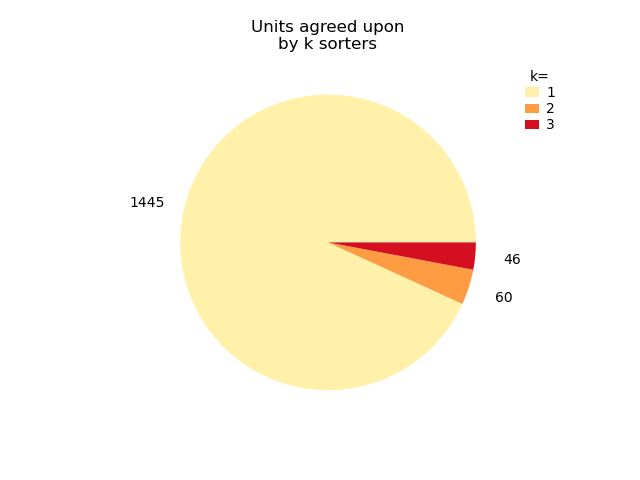

<IPython.core.display.Javascript object>


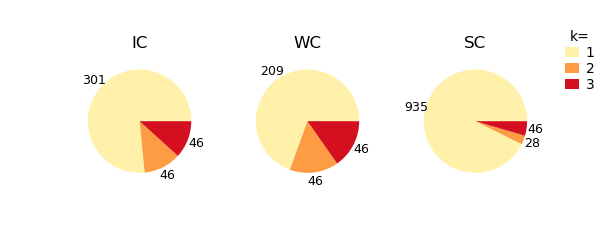

In [42]:
# visualize comaprisons
w = sw.plot_multicomp_agreement(mcmp)
w = sw.plot_multicomp_agreement_by_sorter(mcmp)

In [43]:
# set agreement sorter. min agreement count is the number of sorters that had to agree to count the unit
agreement_sorting = mcmp.get_agreement_sorting(minimum_agreement_count=3)

In [44]:
# get the ids of the common units
ids = agreement_sorting.get_unit_ids()
# show user common unit ids from the primary sorter
print('Common Unit IDs: ', ids)

Common Unit IDs:  [16, 37, 39, 48, 55, 76, 77, 96, 106, 111, 124, 130, 136, 156, 163, 169, 182, 194, 200, 232, 237, 254, 257, 259, 260, 263, 274, 282, 283, 294, 305, 309, 310, 313, 333, 340, 347, 355, 356, 366, 369, 370, 372, 376, 378, 382]


In [45]:
# crucial: cache main sorter and specify location of tmp directory. The tmp directory needs to exist in your system.
# This will eat a lot of space while its processing. I would recomment that you have 2TB+ free in the tmp directory
sorting_IC_cache = se.CacheSortingExtractor(sorting_IC, pth+sess+'processed/ic_sort_results_cache.dat')
sorting_IC_cache.dump_to_pickle(pth+sess+'processed/ic_sorting_cache.pkl')
sorting_IC_cache.set_tmp_folder(pth+sess+'processed/tmp/')

In [46]:
# Export the data to phy for manual curation. This should work, but if it crashes, you will need to do the 
# processing separately. Use the code cells at the end of this docuiment to do that, than rerun this cell.
st.postprocessing.export_to_phy(recording_cache, sorting_IC_cache, 
                                output_folder=pth+sess+'processed/phy_IC', 
                                ms_before=0.5, 
                                ms_after=1, 
                                compute_pc_features=True, 
                                compute_amplitudes=True, 
                                max_spikes_per_unit=None, 
                                compute_property_from_recording=False, 
                                n_jobs=1, 
                                recompute_info=False, 
                                save_property_or_features=False, 
                                verbose=True)

Converting to Phy format
Number of chunks: 84 - Number of jobs: 1


Extracting waveforms in chunks: 100%|########| 84/84 [9:02:23<00:00, 387.42s/it]


Fitting PCA of 3 dimensions on 1657053 waveforms
Projecting waveforms on PC
Saving files
Saved phy format to:  /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/phy_IC
Run:

phy template-gui  /media/paul/storage/Data/Tony/TY20221024_testbattery/processed/phy_IC/params.py


In [47]:
# Set thresholds for metrics
snr_thresh = 5
isi_viol_thresh = 0.5
duration = recording_cache.get_num_frames()

# threshold clusters that have ISI violations > than threshold 
sorting_auto = st.curation.threshold_isi_violations(sorting_IC_cache, isi_viol_thresh, 'greater', duration)
# see how many clusters left and ids of clusters that pass threshold
print('#: ', len(sorting_auto.get_unit_ids()))
print('IDs: ', sorting_auto.get_unit_ids())

#:  359
IDs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 149, 151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 

In [48]:
# threshold clusters that have SNR < threshold
sorting_auto = st.curation.threshold_snrs(sorting_auto, recording_cache, snr_thresh, 'less')
# see how many clusters left and IDs
print('#: ', len(sorting_auto.get_unit_ids()))
print('IDs: ', sorting_auto.get_unit_ids())

#:  229
IDs:  [4, 5, 6, 7, 8, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 32, 33, 34, 36, 37, 38, 39, 40, 41, 43, 45, 46, 47, 48, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 66, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 82, 83, 84, 85, 87, 89, 90, 91, 92, 93, 95, 96, 97, 98, 100, 101, 102, 103, 104, 105, 106, 110, 111, 114, 115, 116, 119, 120, 121, 122, 124, 125, 126, 128, 129, 130, 131, 133, 136, 138, 139, 140, 141, 142, 143, 144, 145, 146, 155, 156, 157, 158, 159, 161, 162, 163, 164, 165, 168, 169, 178, 179, 181, 182, 185, 187, 188, 190, 194, 198, 200, 201, 204, 205, 206, 207, 211, 213, 214, 215, 216, 217, 220, 221, 225, 227, 228, 230, 232, 236, 237, 238, 239, 242, 248, 250, 251, 252, 254, 257, 259, 260, 263, 266, 269, 271, 272, 274, 275, 276, 278, 279, 281, 282, 283, 284, 285, 286, 288, 289, 291, 292, 293, 294, 295, 299, 300, 305, 307, 309, 310, 312, 313, 315, 316, 319, 320, 321, 322, 326, 327, 329, 333, 335, 336, 337, 339, 340, 346, 347, 348, 349, 351, 352, 354, 355, 

In [49]:
# mark as good common units in TDC_sorting
cfile = pth+sess+'processed/phy_IC/cluster_group.tsv'
cg = pd.read_csv(cfile, delimiter='\t')
cg.iloc[sorting_auto.get_unit_ids(), 1] = 'mua'
cg.iloc[ids, 1] = 'good'
cg.to_csv(cfile, index=False, sep='\t') # check to see if the correct units were marked

In [50]:
now = datetime.now()
end_time = now.strftime("%D at %H:%M:%S")
print('Completed: ', end_time)

Completed:  01/09/23 at 22:41:39


## Done!

You should now use Phy to manually curate the results. I recommend having Phy installed in a seprate environment. When you open Phy, all of the clusters should be labeled "mua" (gray), "good" (green), or unlabeled (white). They can also be labeled "noise" (dark gray). You can now go through and adjust the automated curation. You want to check that good units are indeed single units to you, and that none of the mua are actually single units. You also want to check for errors (which should be rare) like: A cluster needs to be split into two. Two clusters need to be mereged. The cluster is really some weird noise. A cluster acually has labeled the same events as another cluster. Remeber to save your work in phy through the menu often.
